# DP Walkthrough (Phase 2)

This notebook explains **what the DP policy is doing and why**.
Focus areas:
- convergence behavior and stability
- why one promo can dominate the policy
- how to read value distributions and heatmaps correctly
- where policy changes across churn, memory, and recency

## Notebook Guide

Use this notebook in two passes:

1. **Core DP walkthrough (Sections 1-16)**: model setup, solve, policy/value interpretation, and artifact workflow.
2. **Appendix diagnostics (Sections 17-21)**: sensitivity diagnostics and constrained grid-search traceability.

Recommended read order for code-level understanding:
- `src/discount_engine/dp/discretization.py`
- `src/discount_engine/dp/transitions.py`
- `src/discount_engine/dp/value_iteration.py`
- `src/discount_engine/dp/policy.py`
- `src/discount_engine/dp/quality_checks.py`
- `scripts/dp_solve.py`, `scripts/dp_validate.py`, `scripts/dp_evaluate.py`

This notebook is kept output-light in git for readability and reproducibility.
Visuals are intentionally curated to high-signal plots only (no low-value chart spam).
Run all cells top-to-bottom to regenerate plots/tables.


## 1) Setup

In [1]:
from dataclasses import replace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from discount_engine.core.params import load_mdp_params
from discount_engine.dp.discretization import (
    MAX_DP_CATEGORIES,
    enumerate_all_states,
    enumerate_live_states,
    resolve_churn_grid,
    resolve_churn_labels,
    terminal_state,
)
from discount_engine.dp.quality_checks import run_quality_checks
from discount_engine.dp.transitions import enumerate_transition_distribution
from discount_engine.dp.value_iteration import ValueIterationConfig, solve_value_iteration


# Resolve repo root robustly whether notebook is launched from repo root or notebooks/.
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    if (PROJECT_ROOT.parent / 'src').exists():
        PROJECT_ROOT = PROJECT_ROOT.parent
    else:
        raise FileNotFoundError('Could not locate project root containing src/.')

DATA_PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
GRID_SEARCH_ROOT = PROJECT_ROOT / 'runs' / 'dp' / 'grid_search'

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update(
    {
        'figure.dpi': 130,
        'axes.titlesize': 13,
        'axes.titleweight': 'bold',
        'axes.labelsize': 11,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'legend.frameon': True,
        'legend.facecolor': 'white',
        'legend.edgecolor': '#d1d5db',
        'grid.alpha': 0.25,
    }
)


/Users/eseide/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Load params and choose `N`

In [2]:
params_path = DATA_PROCESSED_DIR / 'mdp_params.yaml'
n_categories = 3
assert 1 <= n_categories <= MAX_DP_CATEGORIES

full_params = load_mdp_params(params_path)
assert n_categories <= len(full_params.categories)
params = replace(full_params, categories=full_params.categories[:n_categories])

action_labels = {0: 'No Promo'}
for i, cat in enumerate(params.categories, start=1):
    action_labels[i] = f'Promo {i}: {cat.name}'

milk_action = next(
    (i for i, cat in enumerate(params.categories, start=1) if 'milk' in cat.name.lower()),
    None,
)
if milk_action is None:
    milk_action = min(2, n_categories)

focus_action = milk_action
focus_category = params.categories[focus_action - 1].name
focus_m_col = f'm{focus_action}'
focus_r_col = f'r{focus_action}'

churn_grid = resolve_churn_grid(params)
churn_labels = resolve_churn_labels(params)
churn_label_map = {idx: churn_labels[idx] for idx in range(len(churn_labels))}

import discount_engine.dp.discretization as disc

memory_centers = tuple(float(v) for v in disc.MEMORY_GRID)
recency_centers = tuple(float(v) for v in disc.RECENCY_GRID)

def _bucket_labels(centers, names):
    return {
        idx: f"{names[idx]} ({centers[idx]:.2f})"
        for idx in range(len(centers))
    }

memory_bucket_labels = _bucket_labels(memory_centers, ['Low', 'Medium', 'High'])
recency_bucket_labels = _bucket_labels(recency_centers, ['Recent', 'Stale'])

print(f'Loaded params from: {params_path}')
print(f'N={n_categories}')
print(f'Focus category action={focus_action} ({focus_category})')
for a in sorted(action_labels):
    print(f'  action {a}: {action_labels[a]}')

print('\nFocus bucket labels:')
for idx in sorted(memory_bucket_labels):
    print(f'  memory bucket {idx}: {memory_bucket_labels[idx]}')
for idx in sorted(recency_bucket_labels):
    print(f'  recency bucket {idx}: {recency_bucket_labels[idx]}')

print('\nChurn bucket definitions:')
churn_meta = params.metadata.get('churn_bucketing', {}) if isinstance(params.metadata, dict) else {}
buckets = churn_meta.get('buckets', []) if isinstance(churn_meta, dict) else []
if buckets:
    churn_df = pd.DataFrame(buckets)[[
        'index', 'label', 'run_min_inclusive', 'run_max_inclusive', 'run_median', 'churn_center', 'share'
    ]]
    display(churn_df)
else:
    fallback = pd.DataFrame(
        {
            'index': list(churn_label_map.keys()),
            'label': list(churn_label_map.values()),
            'churn_center': list(churn_grid),
        }
    )
    display(fallback)

Loaded params from: /Users/eseide/Stanford/CME-241/cme241-rl-discounts/data/processed/mdp_params.yaml
N=3
Focus category action=2 (FLUID MILK PRODUCTS)
  action 0: No Promo
  action 1: Promo 1: SOFT DRINKS
  action 2: Promo 2: FLUID MILK PRODUCTS
  action 3: Promo 3: BAKED BREAD/BUNS/ROLLS

Focus bucket labels:
  memory bucket 0: Low (0.00)
  memory bucket 1: Medium (0.90)
  memory bucket 2: High (2.00)
  recency bucket 0: Recent (2.00)
  recency bucket 1: Stale (12.00)

Churn bucket definitions:


,index,label,run_min_inclusive,run_max_inclusive,run_median,churn_center,share
0,0,Engaged (low churn risk),0,4,2.0,0.050000,0.338175
1,1,At-Risk (medium churn risk),5,19,9.0,0.145225,0.333650
2,2,Lapsing (high churn risk),20,665,50.0,0.500000,0.328175


## 3) Discretization sanity

In [3]:
live_states = enumerate_live_states(n_categories, churn_grid=churn_grid)
all_states = enumerate_all_states(n_categories, churn_grid=churn_grid)
print('n_live_states =', len(live_states))
print('n_all_states  =', len(all_states))
print('terminal state:', terminal_state(n_categories))

churn_counts = (
    pd.Series([s.churn_bucket for s in live_states], name='churn_bucket')
    .value_counts()
    .sort_index()
    .rename('state_count')
    .to_frame()
)
churn_counts['churn_label'] = [churn_label_map[idx] for idx in churn_counts.index]
churn_counts['state_share'] = churn_counts['state_count'] / churn_counts['state_count'].sum()
display(churn_counts)

n_live_states = 648
n_all_states  = 649
terminal state: DiscreteState(churn_bucket=-1, memory_buckets=(0, 0, 0), recency_buckets=(0, 0, 0))


,state_count,churn_label,state_share
churn_bucket,,,
0,216,Engaged (low churn risk),0.333333
1,216,At-Risk (medium churn risk),0.333333
2,216,Lapsing (high churn risk),0.333333


## 4) Transition sanity for one `(s, a)`

In [4]:
state = live_states[0]
action = 2
branches = enumerate_transition_distribution(state=state, action=action, params=params)
mass = sum(branch.probability for branch in branches)

print('state=', state)
print('action=', action, action_labels[action])
print('num branches=', len(branches))
print(f'total mass={mass:.12f}')

display(pd.DataFrame([
    {'next_state': str(b.next_state), 'reward': b.reward, 'probability': b.probability}
    for b in branches
]).sort_values('probability', ascending=False).head(10))

state= DiscreteState(churn_bucket=0, memory_buckets=(0, 0, 0), recency_buckets=(0, 0, 0))
action= 2 Promo 2: FLUID MILK PRODUCTS
num branches= 71
total mass=1.000000000000


,next_state,reward,probability
69,"DiscreteState(churn_bucket=0, memory_buckets=(...",5.023,0.152030
49,"DiscreteState(churn_bucket=0, memory_buckets=(...",3.033,0.135769
65,"DiscreteState(churn_bucket=0, memory_buckets=(...",3.733,0.101668
41,"DiscreteState(churn_bucket=0, memory_buckets=(...",1.743,0.090794
70,"DiscreteState(churn_bucket=0, memory_buckets=(...",5.023,0.076015
51,"DiscreteState(churn_bucket=0, memory_buckets=(...",3.033,0.067885
67,"DiscreteState(churn_bucket=0, memory_buckets=(...",3.733,0.050834
45,"DiscreteState(churn_bucket=0, memory_buckets=(...",1.743,0.045397
61,"DiscreteState(churn_bucket=0, memory_buckets=(...",3.280,0.035954
33,"DiscreteState(churn_bucket=0, memory_buckets=(...",1.290,0.032108


## 5) Solve Value Iteration

In [5]:
config = ValueIterationConfig(
    gamma=params.gamma,
    epsilon=1e-8,
    max_iters=10000,
    show_progress=True,
    progress_desc=f'Value Iteration (N={n_categories})',
)
result = solve_value_iteration(params=params, config=config)

print('converged =', result.converged)
print('iterations =', result.iterations)
print('final bellman residual =', f'{result.final_bellman_residual:.3e}')
print('last delta =', f'{result.max_delta_history[-1]:.3e}')

converged = True
iterations = 1259
final bellman residual = 9.804e-09
last delta = 9.958e-09


## 6) Build a state-level analysis table

This table is the core for interpretation.
Each row = one live state with chosen action, value, and Q-gap diagnostics.

In [6]:
records = []
for s, a_star in result.policy.items():
    if s.churn_bucket == -1:
        continue

    q_map = result.q_values[s]
    ranked = sorted(q_map.items(), key=lambda kv: kv[1], reverse=True)
    best_q = ranked[0][1]
    second_q = ranked[1][1] if len(ranked) > 1 else ranked[0][1]

    rec = {
        'state': s,
        'action': int(a_star),
        'action_label': action_labels[int(a_star)],
        'value': float(result.values[s]),
        'churn_bucket': int(s.churn_bucket),
        'churn_label': churn_label_map.get(int(s.churn_bucket), f'Churn Segment {int(s.churn_bucket)}'),
        'best_q': float(best_q),
        'second_q': float(second_q),
        'advantage_best_minus_second': float(best_q - second_q),
        'value_loss_if_force_no_promo': float(best_q - q_map[0]),
    }

    for j in range(n_categories):
        rec[f'm{j+1}'] = int(s.memory_buckets[j])
        rec[f'r{j+1}'] = int(s.recency_buckets[j])

    if focus_action in q_map:
        rec['q_focus_minus_q0'] = float(q_map[focus_action] - q_map[0])
        rec['q_focus_minus_best'] = float(q_map[focus_action] - best_q)

    records.append(rec)

df = pd.DataFrame(records)
df['m_mean'] = df[[f'm{j+1}' for j in range(n_categories)]].mean(axis=1)
df['r_mean'] = df[[f'r{j+1}' for j in range(n_categories)]].mean(axis=1)
df['is_focus_action'] = df['action'] == focus_action
df['is_any_promo'] = df['action'] != 0

for j in range(n_categories):
    df[f'm{j+1}_label'] = df[f'm{j+1}'].map(memory_bucket_labels)
    df[f'r{j+1}_label'] = df[f'r{j+1}'].map(recency_bucket_labels)

df['focus_memory_label'] = df[focus_m_col].map(memory_bucket_labels)
df['focus_recency_label'] = df[focus_r_col].map(recency_bucket_labels)

churn_level_order = sorted(churn_label_map)
label_order = [churn_label_map[idx] for idx in churn_level_order]
df['churn_label'] = pd.Categorical(df['churn_label'], categories=label_order, ordered=True)

display(df.head())

,state,action,action_label,value,churn_bucket,churn_label,best_q,second_q,advantage_best_minus_second,value_loss_if_force_no_promo,...,is_focus_action,is_any_promo,m1_label,r1_label,m2_label,r2_label,m3_label,r3_label,focus_memory_label,focus_recency_label
0,"DiscreteState(churn_bucket=0, memory_buckets=(...",0,No Promo,203.801329,0,Engaged (low churn risk),203.801329,202.768864,1.032465,0.0,...,False,False,Low (0.00),Recent (2.00),Low (0.00),Recent (2.00),Low (0.00),Recent (2.00),Low (0.00),Recent (2.00)
1,"DiscreteState(churn_bucket=0, memory_buckets=(...",0,No Promo,203.674070,0,Engaged (low churn risk),203.674070,202.684227,0.989843,0.0,...,False,False,Low (0.00),Recent (2.00),Low (0.00),Recent (2.00),Low (0.00),Stale (12.00),Low (0.00),Recent (2.00)
2,"DiscreteState(churn_bucket=0, memory_buckets=(...",0,No Promo,203.663848,0,Engaged (low churn risk),203.663848,202.646018,1.017831,0.0,...,False,False,Low (0.00),Recent (2.00),Low (0.00),Stale (12.00),Low (0.00),Recent (2.00),Low (0.00),Stale (12.00)
3,"DiscreteState(churn_bucket=0, memory_buckets=(...",0,No Promo,203.534981,0,Engaged (low churn risk),203.534982,202.560124,0.974857,0.0,...,False,False,Low (0.00),Recent (2.00),Low (0.00),Stale (12.00),Low (0.00),Stale (12.00),Low (0.00),Stale (12.00)
4,"DiscreteState(churn_bucket=0, memory_buckets=(...",0,No Promo,203.698662,0,Engaged (low churn risk),203.698662,202.681622,1.017040,0.0,...,False,False,Low (0.00),Stale (12.00),Low (0.00),Recent (2.00),Low (0.00),Recent (2.00),Low (0.00),Recent (2.00)


## 7) Executive summary of learned policy

In [7]:
action_counts = df['action'].value_counts().sort_index()
action_share = (action_counts / len(df)).rename('share')
summary_table = pd.concat([action_counts.rename('count'), action_share], axis=1)
summary_table['label'] = [action_labels[a] for a in summary_table.index]

print('Action distribution over live states:')
display(summary_table)

print('Live-state share by churn segment:')
display(df.groupby(['churn_bucket', 'churn_label']).size().rename('state_count').to_frame())

print('Action share by churn segment (row-normalized):')
display(pd.crosstab(df['churn_label'], df['action'], normalize='index').round(3))

print(f"Focus promo action={focus_action} ({focus_category}) share by churn segment:")
display(df.groupby('churn_label')['is_focus_action'].mean().rename('focus_action_share').to_frame())

Action distribution over live states:


,count,share,label
action,,,
0,225,0.347222,No Promo
2,423,0.652778,Promo 2: FLUID MILK PRODUCTS


Live-state share by churn segment:


/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/1489103178.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(['churn_bucket', 'churn_label']).size().rename('state_count').to_frame())


state_count
churn_bucket churn_label                             
0            Engaged (low churn risk)             216
             At-Risk (medium churn risk)            0
             Lapsing (high churn risk)              0
1            Engaged (low churn risk)               0
             At-Risk (medium churn risk)          216
             Lapsing (high churn risk)              0
2            Engaged (low churn risk)               0
             At-Risk (medium churn risk)            0
             Lapsing (high churn risk)            216

Action share by churn segment (row-normalized):


action,0,2
churn_label,,
Engaged (low churn risk),0.815,0.185
At-Risk (medium churn risk),0.227,0.773
Lapsing (high churn risk),0.000,1.000


Focus promo action=2 (FLUID MILK PRODUCTS) share by churn segment:


/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/1489103178.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('churn_label')['is_focus_action'].mean().rename('focus_action_share').to_frame())


,focus_action_share
churn_label,
Engaged (low churn risk),0.185185
At-Risk (medium churn risk),0.773148
Lapsing (high churn risk),1.000000


## 8) Convergence chart

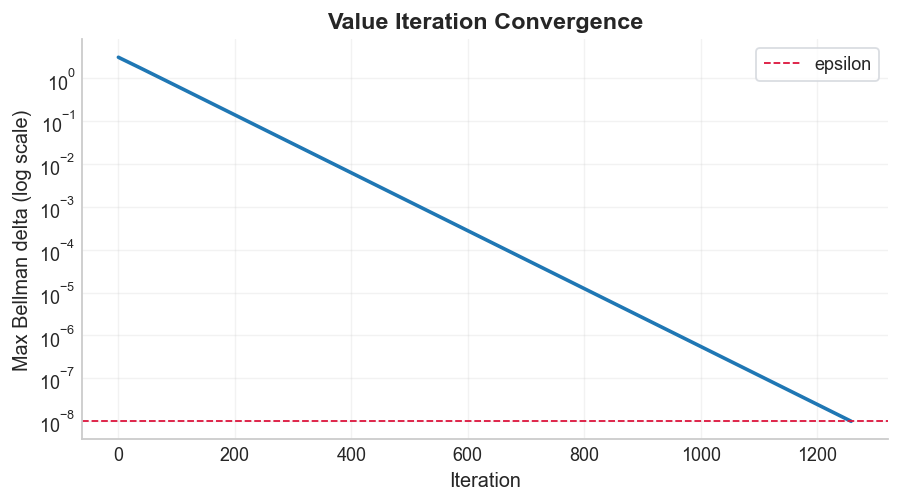

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogy(result.max_delta_history, linewidth=2, color='#1f77b4')
ax.axhline(config.epsilon, linestyle='--', color='crimson', linewidth=1, label='epsilon')
ax.set_title('Value Iteration Convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('Max Bellman delta (log scale)')
ax.legend()
plt.show()

## 9) Interpreting the **Distribution of State Values**

`value` is expected discounted long-run revenue from that state under the optimal policy.

How to read this section:
- a right-shifted distribution means better long-run revenue
- separation by churn segments shows how much churn risk drives value
- heavy overlap means churn is not the only driver; memory/recency also matter
- this is over **state space**, not customer-frequency weighted occupancy

/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/358652577.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1].boxplot(


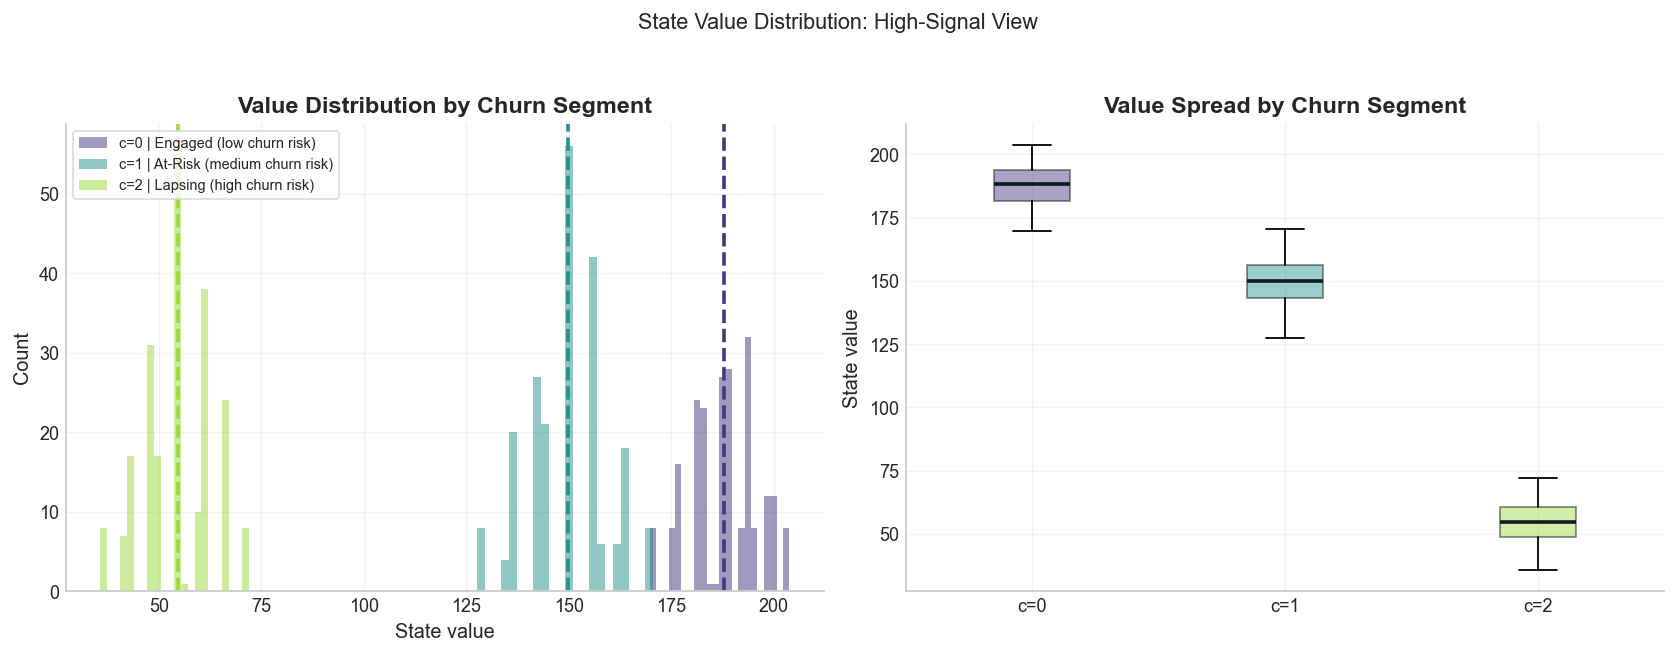

Compact value summary by churn segment:


,churn_bucket,churn_label,count,mean,median,p10,p90
0,0,Engaged (low churn risk),216,187.858,188.320,176.110,199.035
1,1,At-Risk (medium churn risk),216,149.751,149.828,136.056,163.390
2,2,Lapsing (high churn risk),216,54.604,54.802,42.465,66.334


Value summary by selected action:


,action,action_label,count,mean,median
0,0,No Promo,225,184.151,188.188
1,2,Promo 2: FLUID MILK PRODUCTS,423,102.327,71.697


In [9]:
churn_levels = sorted(df['churn_bucket'].unique())
palette = plt.cm.viridis(np.linspace(0.15, 0.85, len(churn_levels)))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8))
box_data = []
box_labels = []
for churn, color in zip(churn_levels, palette):
    sub = df[df['churn_bucket'] == churn]['value']
    label = f"c={churn} | {churn_label_map.get(churn, 'Unknown')}"
    axes[0].hist(sub, bins=22, alpha=0.5, label=label, color=color)
    axes[0].axvline(sub.mean(), color=color, linestyle='--', linewidth=2)
    box_data.append(sub)
    box_labels.append(f'c={churn}')

axes[0].set_title('Value Distribution by Churn Segment')
axes[0].set_xlabel('State value')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=8)

box = axes[1].boxplot(
    box_data,
    labels=box_labels,
    showfliers=False,
    patch_artist=True,
    medianprops={'color': '#111827', 'linewidth': 2},
)
for patch, color in zip(box['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.45)

axes[1].set_title('Value Spread by Churn Segment')
axes[1].set_ylabel('State value')

fig.suptitle('State Value Distribution: High-Signal View', y=1.04)
plt.tight_layout()
plt.show()

print('Compact value summary by churn segment:')
value_summary = (
    df.groupby(['churn_bucket', 'churn_label'], observed=True)['value']
    .agg(
        count='count',
        mean='mean',
        median='median',
        p10=lambda s: s.quantile(0.10),
        p90=lambda s: s.quantile(0.90),
    )
    .reset_index()
)
display(value_summary.round(3))

print('Value summary by selected action:')
action_value = (
    df.groupby('action')['value']
    .agg(count='count', mean='mean', median='median')
    .reset_index()
)
action_value['action_label'] = action_value['action'].map(action_labels)
display(action_value[['action', 'action_label', 'count', 'mean', 'median']].round(3))


## 10) Policy logic slices (why action changes)

These crosstabs isolate the focus category buckets so you can see where policy shifts happen.
Use row-normalized tables to avoid misreading raw counts.

In [10]:
memory_mix = pd.crosstab(
    [df['churn_label'], df['focus_memory_label']],
    df['action'],
    normalize='index',
).round(3)

recency_mix = pd.crosstab(
    [df['churn_label'], df['focus_recency_label']],
    df['action'],
    normalize='index',
).round(3)

print(f'Normalized action mix by churn x memory bucket (focus category: {focus_category}):')
display(memory_mix)

print(f'Normalized action mix by churn x recency bucket (focus category: {focus_category}):')
display(recency_mix)


Normalized action mix by churn x memory bucket (focus category: FLUID MILK PRODUCTS):


action                                              0      2
churn_label                 focus_memory_label              
Engaged (low churn risk)    High (2.00)         0.444  0.556
                            Low (0.00)          1.000  0.000
                            Medium (0.90)       1.000  0.000
At-Risk (medium churn risk) High (2.00)         0.000  1.000
                            Low (0.00)          0.583  0.417
                            Medium (0.90)       0.097  0.903
Lapsing (high churn risk)   High (2.00)         0.000  1.000
                            Low (0.00)          0.000  1.000
                            Medium (0.90)       0.000  1.000

Normalized action mix by churn x recency bucket (focus category: FLUID MILK PRODUCTS):


action                                               0      2
churn_label                 focus_recency_label              
Engaged (low churn risk)    Recent (2.00)        0.833  0.167
                            Stale (12.00)        0.796  0.204
At-Risk (medium churn risk) Recent (2.00)        0.259  0.741
                            Stale (12.00)        0.194  0.806
Lapsing (high churn risk)   Recent (2.00)        0.000  1.000
                            Stale (12.00)        0.000  1.000

## 11) Interpreting the heatmaps (what they are and are not)

Heatmap value = `P(policy chooses focus promo | churn segment, focus-memory bucket, focus-recency bucket)`.

Read each cell as:
- top number: promo probability in that bucket cell
- `n=...`: number of states in that cell (to judge reliability)
- redder color: stronger tendency to choose focus promo

Important: this is over discretized states, not demand-weighted traffic.

/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/2802683352.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


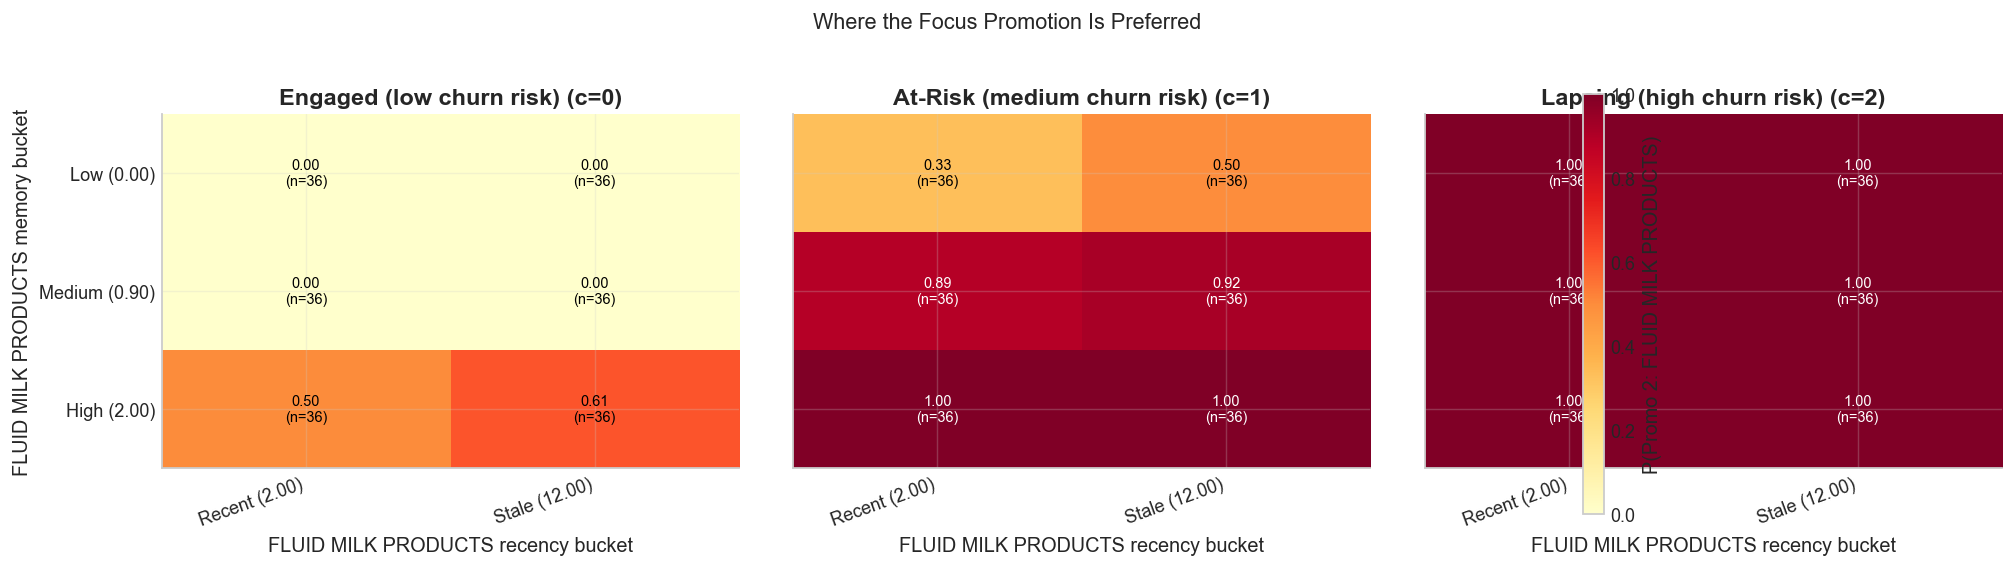

In [11]:
bucket_m = sorted(df[focus_m_col].unique())
bucket_r = sorted(df[focus_r_col].unique())
bucket_m_labels = [memory_bucket_labels[int(b)] for b in bucket_m]
bucket_r_labels = [recency_bucket_labels[int(b)] for b in bucket_r]
churn_levels = sorted(df['churn_bucket'].unique())

fig, axes = plt.subplots(1, len(churn_levels), figsize=(5.2 * len(churn_levels), 4.2), sharex=True, sharey=True)
if len(churn_levels) == 1:
    axes = [axes]

for idx_ax, churn in enumerate(churn_levels):
    ax = axes[idx_ax]
    sub = df[df['churn_bucket'] == churn].copy()

    frac = sub.pivot_table(
        index=focus_m_col,
        columns=focus_r_col,
        values='action',
        aggfunc=lambda x: np.mean(np.array(x) == focus_action),
    ).reindex(index=bucket_m, columns=bucket_r)

    counts = sub.pivot_table(
        index=focus_m_col,
        columns=focus_r_col,
        values='action',
        aggfunc='count',
    ).reindex(index=bucket_m, columns=bucket_r).fillna(0)

    im = ax.imshow(frac.values, vmin=0.0, vmax=1.0, cmap='YlOrRd', aspect='auto')
    ax.set_title(f"{churn_label_map.get(churn, 'Unknown')} (c={churn})")
    ax.set_xlabel(f'{focus_category} recency bucket')
    if idx_ax == 0:
        ax.set_ylabel(f'{focus_category} memory bucket')

    ax.set_xticks(range(len(bucket_r)), bucket_r_labels, rotation=20, ha='right')
    ax.set_yticks(range(len(bucket_m)), bucket_m_labels)

    for i in range(frac.shape[0]):
        for j in range(frac.shape[1]):
            val = frac.values[i, j]
            n = int(counts.values[i, j])
            if pd.isna(val):
                label = '-'
                txt_color = 'black'
            else:
                label = f'{val:.2f}'
                txt_color = 'white' if val >= 0.65 else 'black'
            ax.text(j, i, f'{label}\n(n={n})', ha='center', va='center', color=txt_color, fontsize=8)

fig.colorbar(im, ax=list(axes), label=f'P({action_labels[focus_action]})')
fig.suptitle('Where the Focus Promotion Is Preferred', y=1.03)
plt.tight_layout()
plt.show()


## 11b) Value surface and action-switch frontier

This links policy choice to outcomes:
- mean-value heatmap: where high action probability also corresponds to high value
- all churn panels use a **shared** color scale (so colors are directly comparable)
- delta heatmap (if multiple churn segments): change vs the lowest-churn segment
- switch frontier table: where focus promo stops being used (50% threshold)


/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/1316432268.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


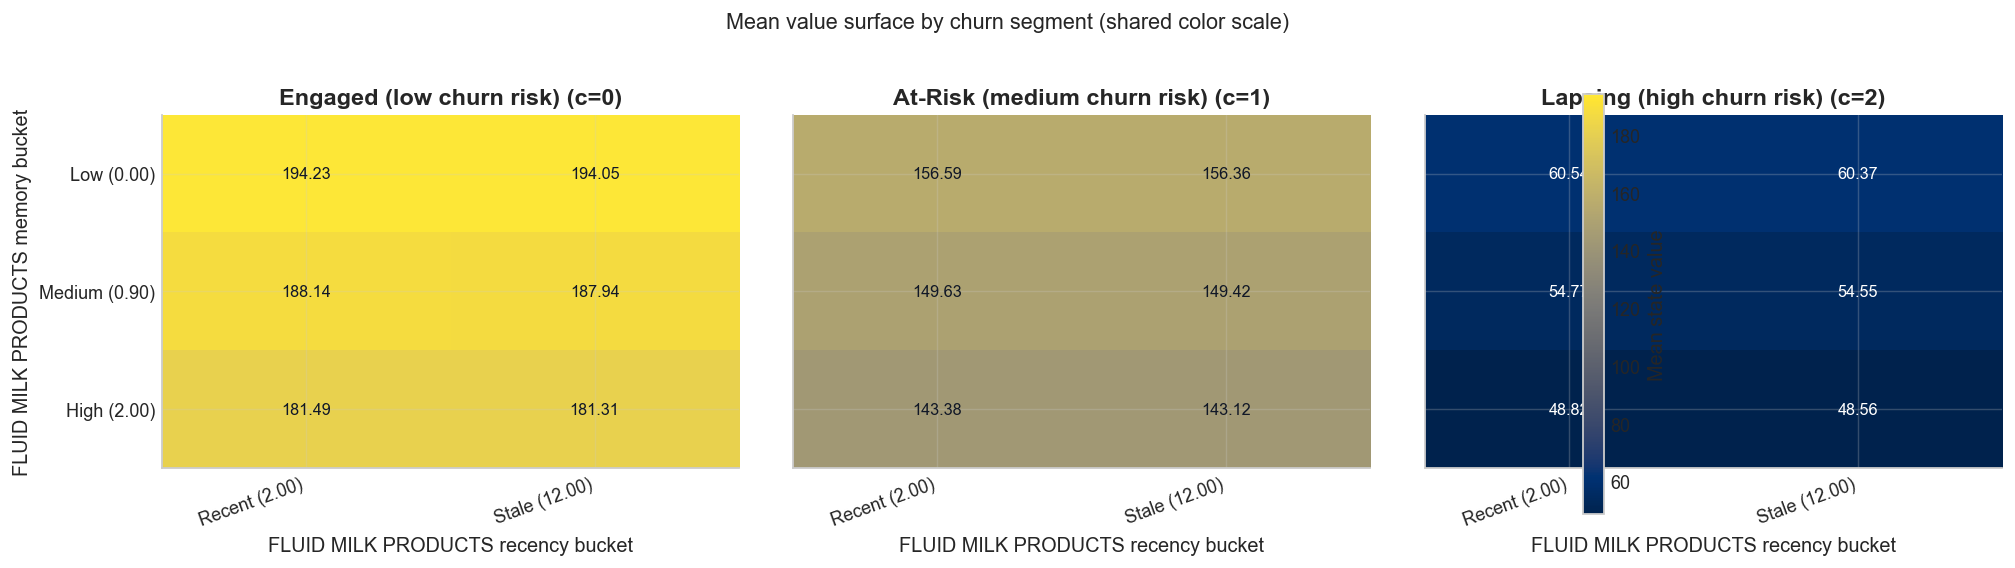

Per-panel value ranges (helps interpret look-alike surfaces):


,churn_bucket,churn_label,min_value,max_value,range
0,0,Engaged (low churn risk),181.307,194.227,12.920
1,1,At-Risk (medium churn risk),143.121,156.589,13.468
2,2,Lapsing (high churn risk),48.564,60.541,11.977


/var/folders/gf/550wq28x3b12kj3pv8149_tr0000gn/T/ipykernel_86825/1316432268.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


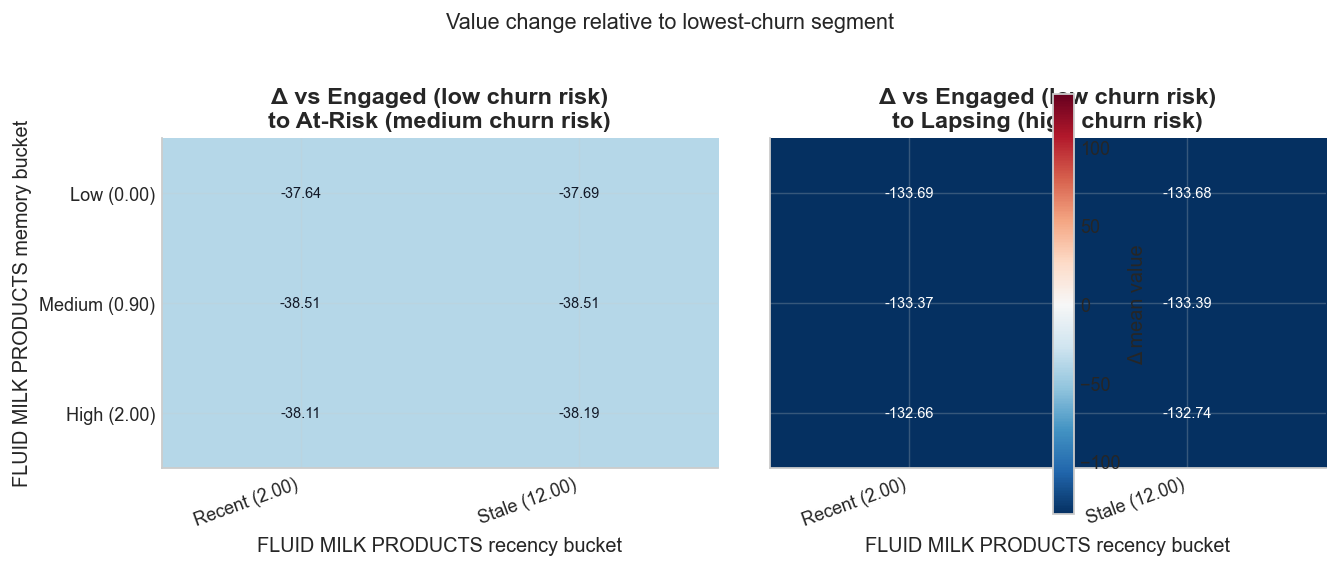

Switch frontier (higher value means promo remains likely deeper into recency):


,churn_bucket,churn_label,m2,focus_memory_label,max_recency_with_focus_prob_ge_0_5,max_recency_label
0,0,Engaged (low churn risk),0,Low (0.00),NaN,None
1,0,Engaged (low churn risk),1,Medium (0.90),NaN,None
2,0,Engaged (low churn risk),2,High (2.00),1.0,Stale (12.00)
3,1,At-Risk (medium churn risk),0,Low (0.00),1.0,Stale (12.00)
4,1,At-Risk (medium churn risk),1,Medium (0.90),1.0,Stale (12.00)
5,1,At-Risk (medium churn risk),2,High (2.00),1.0,Stale (12.00)
6,2,Lapsing (high churn risk),0,Low (0.00),1.0,Stale (12.00)
7,2,Lapsing (high churn risk),1,Medium (0.90),1.0,Stale (12.00)
8,2,Lapsing (high churn risk),2,High (2.00),1.0,Stale (12.00)


In [12]:
churn_levels = sorted(df['churn_bucket'].unique())

# Build surfaces first so we can enforce one global color range across churn panels.
value_surfaces = {}
for churn in churn_levels:
    sub = df[df['churn_bucket'] == churn].copy()
    surface = sub.pivot_table(
        index=focus_m_col,
        columns=focus_r_col,
        values='value',
        aggfunc='mean',
    ).reindex(index=bucket_m, columns=bucket_r)
    value_surfaces[churn] = surface

all_values = np.concatenate(
    [surface.values.ravel() for surface in value_surfaces.values()]
)
finite_values = all_values[np.isfinite(all_values)]
global_vmin = float(finite_values.min())
global_vmax = float(finite_values.max())
value_span = max(global_vmax - global_vmin, 1e-12)

fig, axes = plt.subplots(1, len(churn_levels), figsize=(5.2 * len(churn_levels), 4.2), sharex=True, sharey=True)
if len(churn_levels) == 1:
    axes = [axes]

for idx_ax, churn in enumerate(churn_levels):
    ax = axes[idx_ax]
    value_surface = value_surfaces[churn]
    vals = value_surface.values

    im = ax.imshow(
        vals,
        cmap='cividis',
        aspect='auto',
        vmin=global_vmin,
        vmax=global_vmax,
    )
    ax.set_title(f"{churn_label_map.get(churn, 'Unknown')} (c={churn})")
    ax.set_xlabel(f'{focus_category} recency bucket')
    if idx_ax == 0:
        ax.set_ylabel(f'{focus_category} memory bucket')

    ax.set_xticks(range(len(bucket_r)), bucket_r_labels, rotation=20, ha='right')
    ax.set_yticks(range(len(bucket_m)), bucket_m_labels)

    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            val = vals[i, j]
            if pd.isna(val):
                label = '-'
                txt_color = '#111827'
            else:
                scaled = (val - global_vmin) / value_span
                txt_color = 'white' if scaled < 0.45 else '#111827'
                label = f'{val:.2f}'
            ax.text(j, i, label, ha='center', va='center', color=txt_color, fontsize=9)

fig.colorbar(im, ax=list(axes), label='Mean state value')
fig.suptitle('Mean value surface by churn segment (shared color scale)', y=1.03)
plt.tight_layout()
plt.show()

range_rows = []
for churn in churn_levels:
    vals = value_surfaces[churn].values
    finite = vals[np.isfinite(vals)]
    range_rows.append(
        {
            'churn_bucket': int(churn),
            'churn_label': churn_label_map.get(int(churn), f'Churn Segment {int(churn)}'),
            'min_value': float(np.min(finite)),
            'max_value': float(np.max(finite)),
            'range': float(np.max(finite) - np.min(finite)),
        }
    )

print('Per-panel value ranges (helps interpret look-alike surfaces):')
display(pd.DataFrame(range_rows).round(3))

if len(churn_levels) > 1:
    base_churn = churn_levels[0]
    base_surface = value_surfaces[base_churn].values
    other_levels = churn_levels[1:]
    delta_surfaces = {
        churn: value_surfaces[churn].values - base_surface
        for churn in other_levels
    }
    delta_values = np.concatenate([arr.ravel() for arr in delta_surfaces.values()])
    delta_finite = delta_values[np.isfinite(delta_values)]
    delta_lim = float(np.max(np.abs(delta_finite))) if len(delta_finite) else 1.0
    delta_lim = max(delta_lim, 1e-9)

    fig, axes = plt.subplots(
        1,
        len(other_levels),
        figsize=(5.2 * len(other_levels), 4.2),
        sharex=True,
        sharey=True,
    )
    if len(other_levels) == 1:
        axes = [axes]

    for idx_ax, churn in enumerate(other_levels):
        ax = axes[idx_ax]
        delta = delta_surfaces[churn]
        im_delta = ax.imshow(
            delta,
            cmap='RdBu_r',
            aspect='auto',
            vmin=-delta_lim,
            vmax=delta_lim,
        )
        base_label = churn_label_map.get(base_churn, f'c={base_churn}')
        target_label = churn_label_map.get(churn, f'c={churn}')
        ax.set_title(f'Δ vs {base_label}\nto {target_label}')
        ax.set_xlabel(f'{focus_category} recency bucket')
        if idx_ax == 0:
            ax.set_ylabel(f'{focus_category} memory bucket')

        ax.set_xticks(range(len(bucket_r)), bucket_r_labels, rotation=20, ha='right')
        ax.set_yticks(range(len(bucket_m)), bucket_m_labels)

        for i in range(delta.shape[0]):
            for j in range(delta.shape[1]):
                val = delta[i, j]
                label = 'nan' if pd.isna(val) else f'{val:+.2f}'
                txt_color = 'white' if abs(val) > (0.35 * delta_lim) else '#111827'
                ax.text(j, i, label, ha='center', va='center', color=txt_color, fontsize=8)

    fig.colorbar(im_delta, ax=list(axes), label='Δ mean value')
    fig.suptitle('Value change relative to lowest-churn segment', y=1.03)
    plt.tight_layout()
    plt.show()

frontier = (
    df.assign(is_focus=(df['action'] == focus_action).astype(float))
    .groupby(['churn_bucket', focus_m_col, focus_r_col], as_index=False)['is_focus']
    .mean()
    .rename(columns={'is_focus': 'focus_action_prob'})
)

rows = []
for (churn, mem_bucket), sub in frontier.groupby(['churn_bucket', focus_m_col]):
    eligible = sub[sub['focus_action_prob'] >= 0.5]
    max_recency = int(eligible[focus_r_col].max()) if not eligible.empty else None
    rows.append(
        {
            'churn_bucket': int(churn),
            'churn_label': churn_label_map.get(int(churn), f'Churn Segment {int(churn)}'),
            focus_m_col: int(mem_bucket),
            'focus_memory_label': memory_bucket_labels[int(mem_bucket)],
            'max_recency_with_focus_prob_ge_0_5': max_recency,
            'max_recency_label': recency_bucket_labels.get(max_recency) if max_recency is not None else None,
        }
    )

frontier_table = pd.DataFrame(rows).sort_values(['churn_bucket', focus_m_col])
print('Switch frontier (higher value means promo remains likely deeper into recency):')
display(frontier_table)


## 12) Q-gap diagnostics (confidence of chosen action)

Two useful metrics:
- `advantage_best_minus_second`: policy confidence margin
- `q_focus_minus_q0`: direct counterfactual lift of focus promo vs no-promo
- `value_loss_if_force_no_promo`: what is lost if promo is disallowed

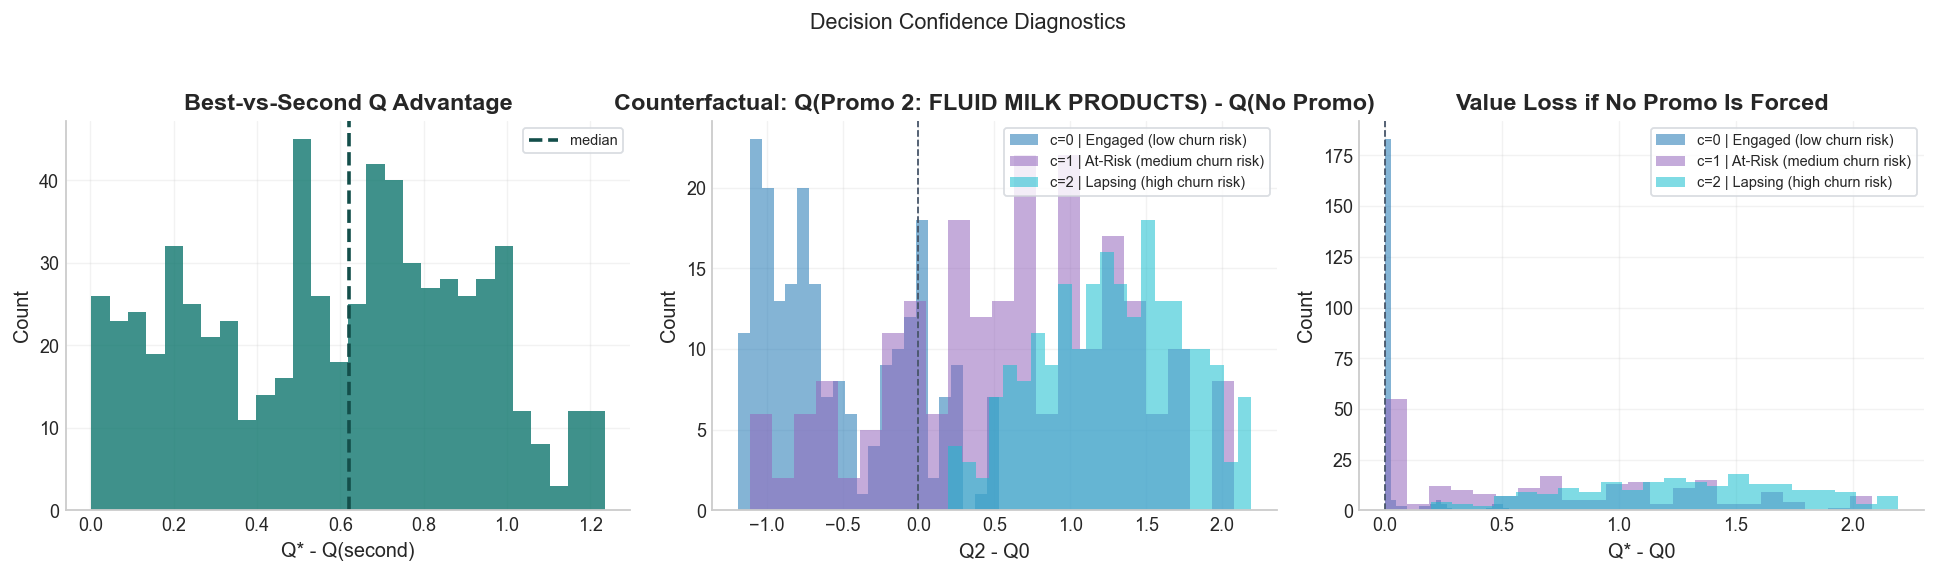

Compact diagnostic summary by churn segment:


,churn_label,adv_median,adv_p90,q_focus_minus_q0_mean,no_promo_loss_mean
0,Engaged (low churn risk),0.329,0.833,-0.528,0.036
1,At-Risk (medium churn risk),0.652,1.177,0.614,0.716
2,Lapsing (high churn risk),0.708,0.935,1.276,1.276


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

axes[0].hist(df['advantage_best_minus_second'], bins=28, color='#0f766e', alpha=0.8)
axes[0].axvline(df['advantage_best_minus_second'].median(), color='#134e4a', linestyle='--', linewidth=2, label='median')
axes[0].set_title('Best-vs-Second Q Advantage')
axes[0].set_xlabel('Q* - Q(second)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=8)

churn_levels = sorted(df['churn_bucket'].unique())
palette = plt.cm.tab10(np.linspace(0.0, 0.9, len(churn_levels)))
for churn, color in zip(churn_levels, palette):
    sub = df[df['churn_bucket'] == churn]['q_focus_minus_q0']
    label = f"c={churn} | {churn_label_map.get(churn, 'Unknown')}"
    axes[1].hist(sub, bins=22, alpha=0.55, label=label, color=color)
axes[1].axvline(0.0, color='#475569', linestyle='--', linewidth=1)
axes[1].set_title(f'Counterfactual: Q({action_labels[focus_action]}) - Q(No Promo)')
axes[1].set_xlabel(f'Q{focus_action} - Q0')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=8)

for churn, color in zip(churn_levels, palette):
    sub = df[df['churn_bucket'] == churn]['value_loss_if_force_no_promo']
    label = f"c={churn} | {churn_label_map.get(churn, 'Unknown')}"
    axes[2].hist(sub, bins=22, alpha=0.55, label=label, color=color)
axes[2].axvline(0.0, color='#475569', linestyle='--', linewidth=1)
axes[2].set_title('Value Loss if No Promo Is Forced')
axes[2].set_xlabel('Q* - Q0')
axes[2].set_ylabel('Count')
axes[2].legend(fontsize=8)

fig.suptitle('Decision Confidence Diagnostics', y=1.04)
plt.tight_layout()
plt.show()

diag_summary = (
    df.groupby('churn_label', observed=True)
    .agg(
        adv_median=('advantage_best_minus_second', 'median'),
        adv_p90=('advantage_best_minus_second', lambda s: s.quantile(0.9)),
        q_focus_minus_q0_mean=('q_focus_minus_q0', 'mean'),
        no_promo_loss_mean=('value_loss_if_force_no_promo', 'mean'),
    )
    .reset_index()
)
print('Compact diagnostic summary by churn segment:')
display(diag_summary.round(3))


## 12b) Value uplift vs a no-promo baseline

This quantifies the business impact of targeted discounting.

Method:
- compute `V_no_promo(s)` by policy evaluation when action is forced to `0` in every live state
- compare optimal `V*(s)` vs `V_no_promo(s)`
- report uplift in absolute terms and percent terms

Uniform state-space mean value: no-promo=127.118, optimal=130.738, uplift=2.85%
Churn-share-weighted mean value: no-promo=127.831, optimal=131.413, uplift=2.80%


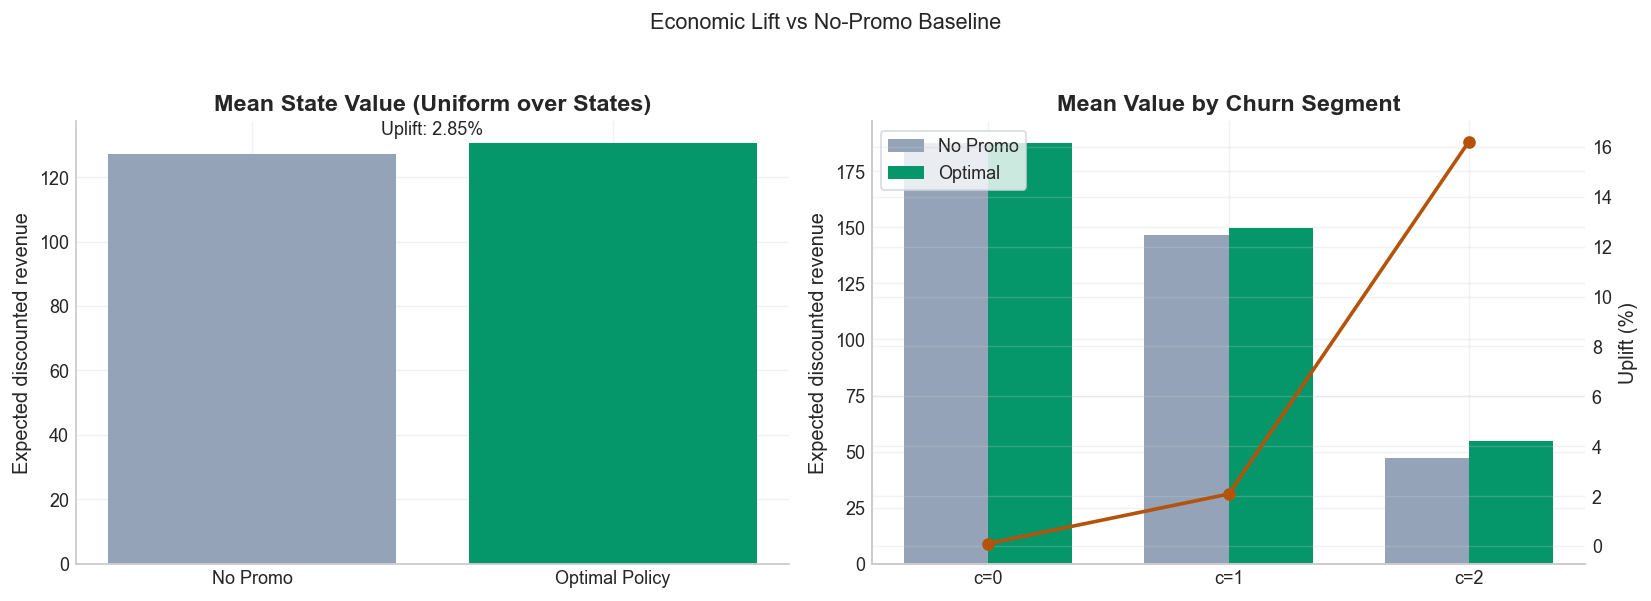

Per-segment uplift summary:


,churn_bucket,churn_label,mean_value_no_promo,mean_value_opt,mean_uplift_pct
0,0,Engaged (low churn risk),187.672,187.858,0.099
1,1,At-Risk (medium churn risk),146.695,149.751,2.084
2,2,Lapsing (high churn risk),46.987,54.604,16.210


In [14]:
# Build no-promo baseline value function V_no_promo via fixed-policy evaluation.
states = sorted(result.values.keys(), key=lambda s: (s.churn_bucket, s.memory_buckets, s.recency_buckets))
state_to_idx = {s: i for i, s in enumerate(states)}

terminal_mask = np.array([s.churn_bucket == -1 for s in states], dtype=bool)
next_idx_cache = []
reward_cache = []
prob_cache = []
for s in states:
    if s.churn_bucket == -1:
        next_idx_cache.append(np.array([state_to_idx[s]], dtype=np.int64))
        reward_cache.append(np.array([0.0], dtype=np.float64))
        prob_cache.append(np.array([1.0], dtype=np.float64))
        continue

    branches = enumerate_transition_distribution(state=s, action=0, params=params)
    next_idx_cache.append(np.array([state_to_idx[b.next_state] for b in branches], dtype=np.int64))
    reward_cache.append(np.array([b.reward for b in branches], dtype=np.float64))
    prob_cache.append(np.array([b.probability for b in branches], dtype=np.float64))

v_no = np.zeros(len(states), dtype=np.float64)
for _ in range(5000):
    v_next = np.zeros_like(v_no)
    max_delta = 0.0
    for i in range(len(states)):
        if terminal_mask[i]:
            continue
        v_i = np.sum(prob_cache[i] * (reward_cache[i] + config.gamma * v_no[next_idx_cache[i]]))
        v_next[i] = v_i
        max_delta = max(max_delta, abs(v_i - v_no[i]))
    v_no = v_next
    if max_delta < 1e-10:
        break

v_no_map = {s: float(v_no[state_to_idx[s]]) for s in states}

df['value_no_promo'] = df['state'].map(v_no_map)
df['value_uplift_abs'] = df['value'] - df['value_no_promo']
df['value_uplift_pct'] = 100.0 * df['value_uplift_abs'] / df['value_no_promo'].clip(lower=1e-9)

uniform_opt = float(df['value'].mean())
uniform_no = float(df['value_no_promo'].mean())
uniform_lift_pct = 100.0 * (uniform_opt - uniform_no) / max(uniform_no, 1e-9)

churn_bucket_shares = {}
for row in params.metadata.get('churn_bucketing', {}).get('buckets', []):
    churn_bucket_shares[int(row['index'])] = float(row['share'])

if churn_bucket_shares:
    by_bucket = df.groupby('churn_bucket')[['value', 'value_no_promo']].mean()
    weighted_opt = 0.0
    weighted_no = 0.0
    for bucket_idx, share in churn_bucket_shares.items():
        if bucket_idx not in by_bucket.index:
            continue
        weighted_opt += share * float(by_bucket.loc[bucket_idx, 'value'])
        weighted_no += share * float(by_bucket.loc[bucket_idx, 'value_no_promo'])
    weighted_lift_pct = 100.0 * (weighted_opt - weighted_no) / max(weighted_no, 1e-9)
else:
    weighted_opt, weighted_no, weighted_lift_pct = uniform_opt, uniform_no, uniform_lift_pct

print(f'Uniform state-space mean value: no-promo={uniform_no:.3f}, optimal={uniform_opt:.3f}, uplift={uniform_lift_pct:.2f}%')
print(f'Churn-share-weighted mean value: no-promo={weighted_no:.3f}, optimal={weighted_opt:.3f}, uplift={weighted_lift_pct:.2f}%')

segment_uplift = (
    df.groupby(['churn_bucket', 'churn_label'], observed=True)
    .agg(
        mean_value_opt=('value', 'mean'),
        mean_value_no_promo=('value_no_promo', 'mean'),
        mean_uplift_abs=('value_uplift_abs', 'mean'),
    )
    .reset_index()
)
segment_uplift['mean_uplift_pct'] = (
    100.0
    * (segment_uplift['mean_value_opt'] - segment_uplift['mean_value_no_promo'])
    / segment_uplift['mean_value_no_promo'].clip(lower=1e-9)
)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.4))

axes[0].bar(['No Promo', 'Optimal Policy'], [uniform_no, uniform_opt], color=['#94a3b8', '#059669'])
axes[0].set_title('Mean State Value (Uniform over States)')
axes[0].set_ylabel('Expected discounted revenue')
axes[0].text(0.5, max(uniform_no, uniform_opt) * 1.01, f'Uplift: {uniform_lift_pct:.2f}%', ha='center', va='bottom')

x = np.arange(len(segment_uplift))
width = 0.35
axes[1].bar(x - width/2, segment_uplift['mean_value_no_promo'], width=width, label='No Promo', color='#94a3b8')
axes[1].bar(x + width/2, segment_uplift['mean_value_opt'], width=width, label='Optimal', color='#059669')
axes[1].set_xticks(x, [f"c={int(c)}" for c in segment_uplift['churn_bucket']])
axes[1].set_title('Mean Value by Churn Segment')
axes[1].set_ylabel('Expected discounted revenue')
axes[1].legend(loc='upper left')

ax2 = axes[1].twinx()
ax2.plot(x, segment_uplift['mean_uplift_pct'], color='#b45309', marker='o', linewidth=2, label='Uplift %')
ax2.set_ylabel('Uplift (%)')

fig.suptitle('Economic Lift vs No-Promo Baseline', y=1.04)
plt.tight_layout()
plt.show()

print('Per-segment uplift summary:')
display(segment_uplift[['churn_bucket', 'churn_label', 'mean_value_no_promo', 'mean_value_opt', 'mean_uplift_pct']].round(3))


## 13) Sensitivity: how addiction strength (`beta_m`) changes policy

This is a quick sanity sweep showing when policy collapses vs diversifies.

,beta_m,promo_rate,focus_action_rate,n_no_promo
0,0.0000,1.0000,1.0000,0
1,0.3000,1.0000,1.0000,0
2,0.5519,0.6528,0.6528,225
3,1.0000,0.0957,0.0957,586
4,1.5000,0.0123,0.0123,640
5,3.0000,0.0000,0.0000,648


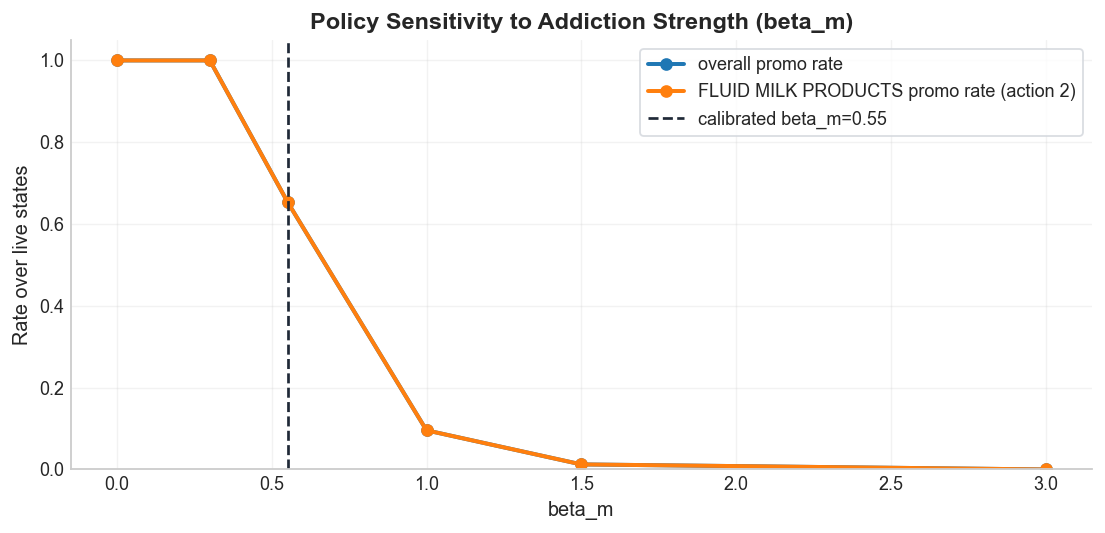

In [15]:
beta_m_grid = [0.0, 0.3, float(params.beta_m), 1.0, 1.5, 3.0]
sens_rows = []

for bm in beta_m_grid:
    p_bm = replace(params, beta_m=bm)
    r_bm = solve_value_iteration(
        params=p_bm,
        config=ValueIterationConfig(gamma=p_bm.gamma, epsilon=1e-8, max_iters=3000, show_progress=False),
    )

    actions = [a for s, a in r_bm.policy.items() if s.churn_bucket != -1]
    actions_arr = np.array(actions)
    promo_rate = np.mean(actions_arr != 0)
    focus_rate = np.mean(actions_arr == focus_action)
    sens_rows.append({
        'beta_m': bm,
        'promo_rate': float(promo_rate),
        'focus_action_rate': float(focus_rate),
        'n_no_promo': int(np.sum(actions_arr == 0)),
    })

sens_df = pd.DataFrame(sens_rows).sort_values('beta_m')
display(sens_df.round(4))

fig, ax = plt.subplots(figsize=(8.6, 4.2))
ax.plot(sens_df['beta_m'], sens_df['promo_rate'], marker='o', linewidth=2.2, label='overall promo rate')
ax.plot(
    sens_df['beta_m'],
    sens_df['focus_action_rate'],
    marker='o',
    linewidth=2.2,
    label=f'{focus_category} promo rate (action {focus_action})',
)
ax.axvline(float(params.beta_m), linestyle='--', color='#1f2937', linewidth=1.5, label=f'calibrated beta_m={params.beta_m:.2f}')
ax.set_title('Policy Sensitivity to Addiction Strength (beta_m)')
ax.set_xlabel('beta_m')
ax.set_ylabel('Rate over live states')
ax.set_ylim(0, 1.05)
ax.legend(loc='best')
plt.tight_layout()
plt.show()


## 14) Highest and lowest value states

In [16]:
top_states = df.sort_values('value', ascending=False).head(10)
bottom_states = df.sort_values('value', ascending=True).head(10)

state_cols = ['churn_bucket', 'churn_label'] + [f'm{j+1}' for j in range(n_categories)] + [f'r{j+1}' for j in range(n_categories)]
show_cols = state_cols + ['action', 'action_label', 'value']

print('Top 10 states by value')
display(top_states[show_cols])

print('Bottom 10 states by value')
display(bottom_states[show_cols])

Top 10 states by value


,churn_bucket,churn_label,m1,m2,m3,r1,r2,r3,action,action_label,value
0,0,Engaged (low churn risk),0,0,0,0,0,0,0,No Promo,203.801329
4,0,Engaged (low churn risk),0,0,0,1,0,0,0,No Promo,203.698662
1,0,Engaged (low churn risk),0,0,0,0,0,1,0,No Promo,203.674070
2,0,Engaged (low churn risk),0,0,0,0,1,0,0,No Promo,203.663848
5,0,Engaged (low churn risk),0,0,0,1,0,1,0,No Promo,203.569742
6,0,Engaged (low churn risk),0,0,0,1,1,0,0,No Promo,203.559387
3,0,Engaged (low churn risk),0,0,0,0,1,1,0,No Promo,203.534981
7,0,Engaged (low churn risk),0,0,0,1,1,1,0,No Promo,203.428806
72,0,Engaged (low churn risk),1,0,0,0,0,0,0,No Promo,199.619581
76,0,Engaged (low churn risk),1,0,0,1,0,0,0,No Promo,199.496696


Bottom 10 states by value


,churn_bucket,churn_label,m1,m2,m3,r1,r2,r3,action,action_label,value
647,2,Lapsing (high churn risk),2,2,2,1,1,1,2,Promo 2: FLUID MILK PRODUCTS,35.665394
643,2,Lapsing (high churn risk),2,2,2,0,1,1,2,Promo 2: FLUID MILK PRODUCTS,35.906516
646,2,Lapsing (high churn risk),2,2,2,1,1,0,2,Promo 2: FLUID MILK PRODUCTS,35.909841
645,2,Lapsing (high churn risk),2,2,2,1,0,1,2,Promo 2: FLUID MILK PRODUCTS,35.956320
642,2,Lapsing (high churn risk),2,2,2,0,1,0,2,Promo 2: FLUID MILK PRODUCTS,36.149916
641,2,Lapsing (high churn risk),2,2,2,0,0,1,2,Promo 2: FLUID MILK PRODUCTS,36.195058
644,2,Lapsing (high churn risk),2,2,2,1,0,0,2,Promo 2: FLUID MILK PRODUCTS,36.199016
640,2,Lapsing (high churn risk),2,2,2,0,0,0,2,Promo 2: FLUID MILK PRODUCTS,36.436706
639,2,Lapsing (high churn risk),2,2,1,1,1,1,2,Promo 2: FLUID MILK PRODUCTS,41.751765
635,2,Lapsing (high churn risk),2,2,1,0,1,1,2,Promo 2: FLUID MILK PRODUCTS,41.989881


## 15) Quality checks

In [17]:
quality = run_quality_checks(
    params=params,
    values=result.values,
    policy=result.policy,
    q_values=result.q_values,
    gamma=config.gamma,
    bellman_atol=1e-6,
    strict_conceptual=False,
)
qp = quality.to_dict()

print('overall passed =', quality.passed)
print('hard failures =', len(quality.hard_failures))
print('conceptual warnings =', len(quality.conceptual_warnings))

display(pd.DataFrame(qp['hard_checks']))
display(pd.DataFrame(qp['conceptual_checks']))

overall passed = True
hard failures = 0
conceptual warnings = 1


,name,passed,details,metric
0,parameter_domains,True,parameter domains valid,NaN
1,policy_action_range,True,"all policy actions in [0, 3]",NaN
2,terminal_invariants,True,terminal state is absorbing with zero reward,NaN
3,transition_probabilities,True,validated 2596 state-action distributions,NaN
4,q_values_coverage,True,q-values cover all states and actions,NaN
5,bellman_residual,True,bellman residual 9.804e-09 <= atol 1.000e-06,9.804239e-09


,name,passed,details,metric
0,value_ordering_by_churn,True,0/432 churn-order violations (rate=0.000),0.000000
1,policy_collapse,True,dominant action share=0.653,0.652778
2,memory_addiction_intuition,False,"promotion_rate(high_memory)=0.917, promotion_r...",0.572917
3,recency_intuition,True,"promotion_rate(stale)=0.691, promotion_rate(re...",0.074074


## 16) CLI artifact workflow

```bash
python scripts/dp_solve.py --n-categories 3 --tag walkthrough
python scripts/dp_validate.py --run-dir runs/dp/<timestamp_tag>
python scripts/dp_evaluate.py --run-dir runs/dp/<timestamp_tag>
```

Expected files:
- `config_resolved.yaml`
- `values.json`
- `policy.json`
- `q_values.json`
- `solver_metrics.json`
- `policy_table.csv`
- `quality_report.json`
- `quality_warnings.json`
- `evaluation_summary.json`

## Appendix: Diagnostic and Selection Analysis

Sections 17-21 are supplementary diagnostics used to stress-test policy behavior and justify the final data-driven discretization defaults.


## 17) Diagnostic: Why recency/popularity may look muted

This section decomposes logit terms and Q-value sensitivity before changing any bins.

In [18]:
from discount_engine.dp.discretization import decode_state

diag_rows = []
for s, a_star in result.policy.items():
    if s.churn_bucket == -1:
        continue
    decoded = decode_state(s, churn_grid=churn_grid)
    for idx, cat in enumerate(params.categories):
        promoted = int(a_star) == (idx + 1)
        eff_price = cat.price * (1.0 - params.delta) if promoted else cat.price
        deal_signal = cat.price - eff_price

        baseline_term = float(cat.beta_0)
        deal_term = float(params.beta_p * deal_signal)
        recency_term = float(-params.beta_l * decoded.purchase_recency[idx])
        memory_term = float(-params.beta_m * decoded.discount_memory[idx])
        logit = baseline_term + deal_term + recency_term + memory_term

        diag_rows.append({
            'state': s,
            'action': int(a_star),
            'category_idx': idx + 1,
            'category': cat.name,
            'promoted': promoted,
            'baseline_term': baseline_term,
            'deal_term': deal_term,
            'recency_term': recency_term,
            'memory_term': memory_term,
            'logit': logit,
            'p_buy': 1.0 / (1.0 + np.exp(-logit)),
        })

diag_df = pd.DataFrame(diag_rows)

term_summary = pd.DataFrame(
    {
        'mean_abs': [
            diag_df['baseline_term'].abs().mean(),
            diag_df['deal_term'].abs().mean(),
            diag_df['recency_term'].abs().mean(),
            diag_df['memory_term'].abs().mean(),
        ],
        'p95_abs': [
            diag_df['baseline_term'].abs().quantile(0.95),
            diag_df['deal_term'].abs().quantile(0.95),
            diag_df['recency_term'].abs().quantile(0.95),
            diag_df['memory_term'].abs().quantile(0.95),
        ],
        'max_abs': [
            diag_df['baseline_term'].abs().max(),
            diag_df['deal_term'].abs().max(),
            diag_df['recency_term'].abs().max(),
            diag_df['memory_term'].abs().max(),
        ],
    },
    index=['baseline', 'deal', 'recency', 'memory'],
)

print('Logit term magnitudes under the learned policy:')
display(term_summary.round(4))

beta0_vs_policy = pd.DataFrame({
    'category_idx': list(range(1, n_categories + 1)),
    'category': [c.name for c in params.categories],
    'beta_0': [float(c.beta_0) for c in params.categories],
    'price': [float(c.price) for c in params.categories],
})

live_actions = pd.Series([int(result.policy[s]) for s in result.policy if s.churn_bucket != -1])
action_share = (live_actions.value_counts().sort_index() / len(live_actions)).to_dict()
beta0_vs_policy['policy_action_share'] = [action_share.get(j, 0.0) for j in range(1, n_categories + 1)]
beta0_vs_policy['mean_buy_prob_under_policy'] = [
    float(diag_df[diag_df['category_idx'] == j]['p_buy'].mean())
    for j in range(1, n_categories + 1)
]

print('Popularity proxies vs realized policy share:')
display(beta0_vs_policy.round(4))


Logit term magnitudes under the learned policy:


,mean_abs,p95_abs,max_abs
baseline,0.1853,0.3104,0.3104
deal,0.2449,1.1255,1.1255
recency,0.0469,0.0804,0.0804
memory,0.5335,1.1038,1.1038


Popularity proxies vs realized policy share:


,category_idx,category,beta_0,price,policy_action_share,mean_buy_prob_under_policy
0,1,SOFT DRINKS,0.3104,1.29,0.0000,0.4363
1,2,FLUID MILK PRODUCTS,0.2244,2.49,0.6528,0.5871
2,3,BAKED BREAD/BUNS/ROLLS,0.0212,1.99,0.0000,0.3701


In [19]:
# Pair states that differ only in one category's recency bucket (0 -> 1).
state_set = {s for s in result.policy if s.churn_bucket != -1}
pair_rows = []
for s in state_set:
    for j in range(n_categories):
        if s.recency_buckets[j] != 0:
            continue
        alt_rec = list(s.recency_buckets)
        alt_rec[j] = 1
        s2 = type(s)(
            churn_bucket=s.churn_bucket,
            memory_buckets=s.memory_buckets,
            recency_buckets=tuple(alt_rec),
        )
        if s2 not in state_set:
            continue

        q1 = result.q_values[s]
        q2 = result.q_values[s2]
        for a in range(n_categories + 1):
            pair_rows.append({
                'category_idx': j + 1,
                'action': a,
                'delta_q_recent_minus_stale': float(q1[a] - q2[a]),
            })
        pair_rows.append({
            'category_idx': j + 1,
            'action': -1,
            'delta_q_recent_minus_stale': float(max(q1.values()) - max(q2.values())),
        })

pair_df = pd.DataFrame(pair_rows)

print('Q sensitivity to recency by category/action:')
display(
    pair_df[pair_df['action'] >= 0]
    .groupby(['category_idx', 'action'])['delta_q_recent_minus_stale']
    .agg(['mean', 'median', 'min', 'max'])
    .round(4)
)

print('Optimal value sensitivity to recency (V* recent - stale):')
display(
    pair_df[pair_df['action'] == -1]
    .groupby('category_idx')['delta_q_recent_minus_stale']
    .agg(['mean', 'median', 'min', 'max'])
    .round(4)
)


Q sensitivity to recency by category/action:


mean  median     min     max
category_idx action                                
1            0       0.2263  0.2356  0.1027  0.3389
             1       0.1967  0.2052  0.0775  0.3295
             2       0.1773  0.1760  0.0829  0.2829
             3       0.1888  0.1925  0.0872  0.2970
2            0       0.2537  0.2624  0.1375  0.3692
             1       0.2280  0.2312  0.1276  0.3455
             2       0.1833  0.1720  0.0746  0.3351
             3       0.2184  0.2195  0.1228  0.3351
3            0       0.2387  0.2476  0.1273  0.3504
             1       0.2164  0.2187  0.1187  0.3207
             2       0.1981  0.1975  0.1106  0.2930
             3       0.1973  0.2022  0.0846  0.3270

Optimal value sensitivity to recency (V* recent - stale):


,mean,median,min,max
category_idx,,,,
1,0.1888,0.1856,0.1027,0.2829
2,0.2106,0.1992,0.1303,0.3351
3,0.2076,0.2058,0.1273,0.2930


## 18) Diagnostic-only candidate data-driven bucket centers

This cell reconstructs panel-level recency/memory distributions and proposes candidate centers. No solver behavior is changed here.

In [20]:
from discount_engine.core import calibration as calib
import discount_engine.dp.discretization as disc

processed_dir = DATA_PROCESSED_DIR
category_column = 'commodity_desc'
tables, _ = calib._load_processed_tables_with_fallback(processed_dir)
transactions = calib._prepare_transactions(tables['transaction_data'])
products = calib._prepare_products(
    tables['product'],
    product_ids=set(transactions['product_id']),
    category_column=category_column,
)
merged = transactions.merge(
    products[['product_id', category_column]],
    on='product_id',
    how='inner',
)
merged = calib._compute_price_and_discount_signals(merged)
selected = calib._select_top_categories(merged, category_column, n_categories)
merged = merged[merged[category_column].isin(selected)].copy()
time_column = calib._detect_time_column(merged)
panel, _ = calib._build_purchase_panel(
    merged=merged,
    category_column=category_column,
    selected_categories=selected,
    time_column=time_column,
)

memory_values = calib._compute_memory_feature(panel=panel, alpha=float(params.alpha))
recency_values = panel['recency'].to_numpy(dtype=float)

quantiles = pd.DataFrame(
    {
        'recency': np.quantile(recency_values, [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]),
        'memory': np.quantile(memory_values, [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]),
    },
    index=['q10', 'q25', 'q50', 'q75', 'q90', 'q95'],
)

# Candidate set for discussion only (quantile-based centers).
candidate_recency_centers = [
    float(np.quantile(recency_values, 0.30)),
    float(np.quantile(recency_values, 0.75)),
]
candidate_memory_centers = [
    float(np.quantile(memory_values, 0.20)),
    float(np.quantile(memory_values, 0.55)),
    float(np.quantile(memory_values, 0.85)),
]

current_recency_grid = tuple(float(v) for v in disc.RECENCY_GRID)
current_memory_grid = tuple(float(v) for v in disc.MEMORY_GRID)

print('selected_categories =', selected)
print('current recency grid =', [round(v, 4) for v in current_recency_grid])
print('candidate recency centers =', [round(v, 4) for v in candidate_recency_centers])
print('current memory grid =', [round(v, 4) for v in current_memory_grid])
print('candidate memory centers =', [round(v, 4) for v in candidate_memory_centers])

display(quantiles.round(4))

def bucket_edges_from_centers(centers):
    centers = list(centers)
    mids = [(centers[i] + centers[i + 1]) / 2 for i in range(len(centers) - 1)]
    return [-np.inf, *mids, np.inf]

rec_edges = bucket_edges_from_centers(current_recency_grid)
rec_labels = [f'r{i}' for i in range(len(current_recency_grid))]
rec_bins = pd.cut(recency_values, bins=rec_edges, labels=rec_labels)
rec_share = rec_bins.value_counts().sort_index() / len(rec_bins)

mem_edges = bucket_edges_from_centers(current_memory_grid)
mem_labels = [f'm{i}' for i in range(len(current_memory_grid))]
mem_bins = pd.cut(memory_values, bins=mem_edges, labels=mem_labels)
mem_share = mem_bins.value_counts().sort_index() / len(mem_bins)

display(pd.DataFrame({'current_recency_bucket_share': rec_share}).round(4))
display(pd.DataFrame({'current_memory_bucket_share': mem_share}).round(4))


selected_categories = ['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'BAKED BREAD/BUNS/ROLLS']
current recency grid = [2.0, 12.0]
candidate recency centers = [5.0, 23.0]
current memory grid = [0.0, 0.9, 2.0]
candidate memory centers = [0.001, 0.0784, 0.3492]


,recency,memory
q10,1.0,0.0000
q25,4.0,0.0041
q50,9.0,0.0582
q75,23.0,0.2311
q90,57.0,0.4348
q95,100.0,0.5785


,current_recency_bucket_share
r0,0.438
r1,0.562


,current_memory_bucket_share
m0,0.907
m1,0.092
m2,0.001


## 19) Controlled A/B sweep for discretization grids

Compare a small set of **interpretable** variants under identical solver settings:
- current default grid,
- legacy baseline grid,
- quantile-derived candidate grid,
- one aggressive recency-heavy candidate.

This keeps the section focused on interesting trade-offs only (value, recency sensitivity, and policy concentration).


,variant,dominant_action_share,entropy_norm,promo_rate,uplift_pct_uniform,recency_delta_vstar_overall,hard_failures,conceptual_warnings
0,legacy_baseline,0.6420,0.4705,0.6420,2.8424,0.0922,0,memory_addiction_intuition
1,current_default,0.6528,0.4658,0.6528,2.8477,0.2024,0,memory_addiction_intuition
2,quantile_candidate,1.0000,-0.0000,1.0000,30.9367,0.2982,0,policy_collapse
3,aggressive_recency,0.7269,0.4230,0.7269,3.4607,0.4244,0,memory_addiction_intuition


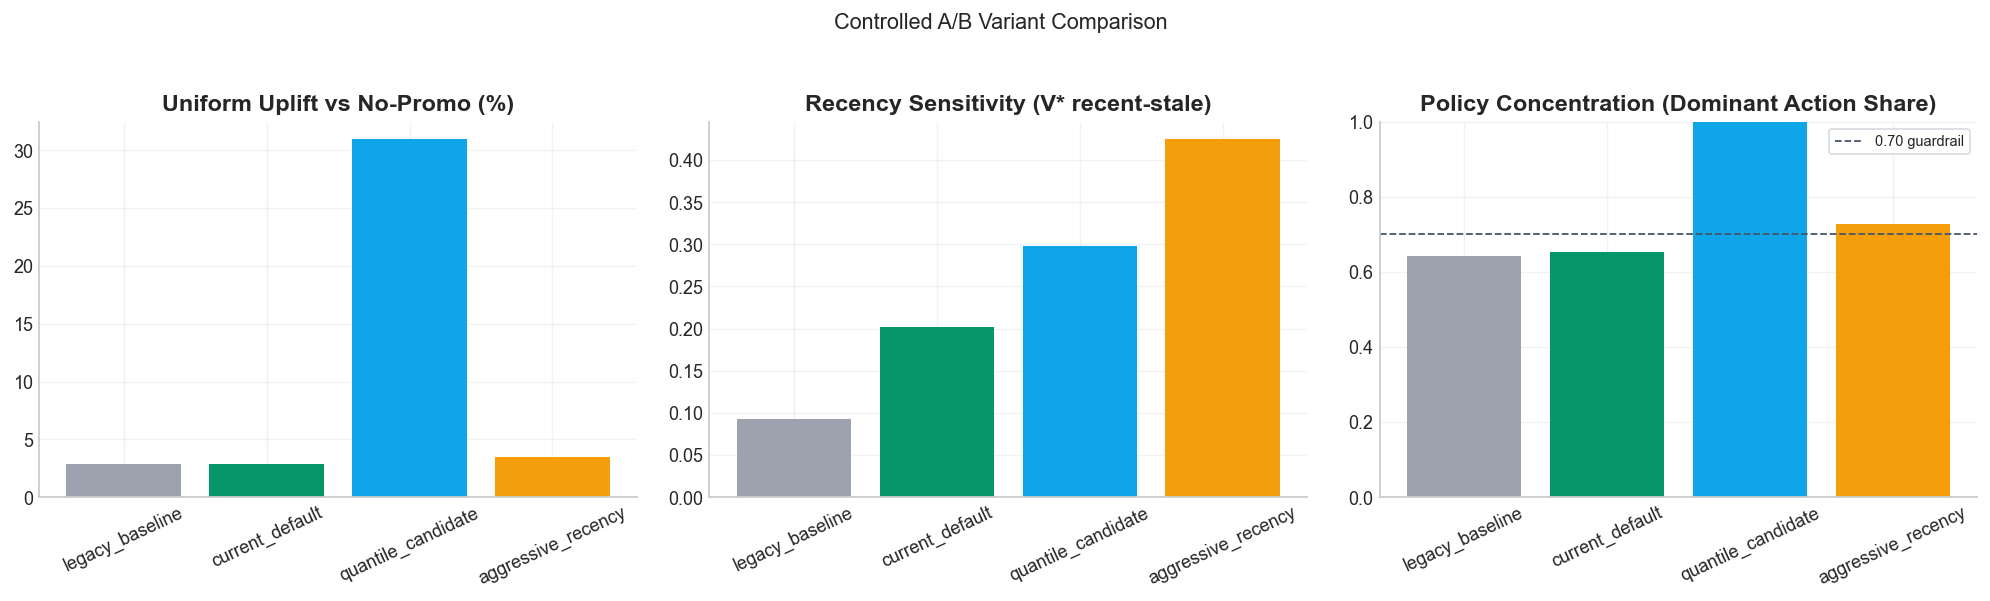

In [21]:
from collections import Counter
import math

import discount_engine.dp.discretization as disc

base_memory = tuple(float(v) for v in disc.MEMORY_GRID)
base_recency = tuple(float(v) for v in disc.RECENCY_GRID)
quant_memory = tuple(float(v) for v in candidate_memory_centers)
quant_recency = tuple(float(v) for v in candidate_recency_centers)

variants = {
    'current_default': (base_memory, base_recency),
    'legacy_baseline': ((0.0, 1.0, 2.0), (0.0, 5.0)),
    'quantile_candidate': (quant_memory, quant_recency),
    'aggressive_recency': ((0.05, 1.0, 2.0), (10.0, 30.0)),
}

def eval_no_promo(states, state_to_idx):
    term_mask = np.array([s.churn_bucket == -1 for s in states], dtype=bool)
    next_idx_cache, rew_cache, prob_cache = [], [], []
    for s in states:
        if s.churn_bucket == -1:
            next_idx_cache.append(np.array([state_to_idx[s]], dtype=np.int64))
            rew_cache.append(np.array([0.0], dtype=np.float64))
            prob_cache.append(np.array([1.0], dtype=np.float64))
            continue
        branches = enumerate_transition_distribution(state=s, action=0, params=params)
        next_idx_cache.append(np.array([state_to_idx[b.next_state] for b in branches], dtype=np.int64))
        rew_cache.append(np.array([b.reward for b in branches], dtype=np.float64))
        prob_cache.append(np.array([b.probability for b in branches], dtype=np.float64))

    v = np.zeros(len(states), dtype=np.float64)
    for _ in range(5000):
        v_next = np.zeros_like(v)
        delta = 0.0
        for i in range(len(states)):
            if term_mask[i]:
                continue
            v_i = float(np.sum(prob_cache[i] * (rew_cache[i] + config.gamma * v[next_idx_cache[i]])))
            v_next[i] = v_i
            delta = max(delta, abs(v_i - v[i]))
        v = v_next
        if delta < 1e-10:
            break
    return v

def recency_vstar_delta(res):
    live_states = [s for s in res.policy if s.churn_bucket != -1]
    state_set = set(live_states)
    rows = []
    for s in live_states:
        for j in range(n_categories):
            if s.recency_buckets[j] != 0:
                continue
            r2 = list(s.recency_buckets)
            r2[j] = 1
            s2 = type(s)(churn_bucket=s.churn_bucket, memory_buckets=s.memory_buckets, recency_buckets=tuple(r2))
            if s2 not in state_set:
                continue
            rows.append(max(res.q_values[s].values()) - max(res.q_values[s2].values()))
    return float(np.mean(rows)) if rows else float('nan')

sweep_rows = []
for name, (m_grid, r_grid) in variants.items():
    with disc.temporary_bucket_grids(memory_grid=m_grid, recency_grid=r_grid):
        res = solve_value_iteration(params=params, config=config)
        quality = run_quality_checks(
            params=params,
            values=res.values,
            policy=res.policy,
            q_values=res.q_values,
            gamma=config.gamma,
            strict_conceptual=False,
        )

        live_states = [s for s in res.policy if s.churn_bucket != -1]
        actions = [int(res.policy[s]) for s in live_states]
        cnt = Counter(actions)
        probs = np.array([cnt.get(a, 0) / len(live_states) for a in range(n_categories + 1)], dtype=float)
        nonzero = probs[probs > 0]
        entropy_norm = float(-(nonzero * np.log(nonzero)).sum() / math.log(n_categories + 1)) if len(nonzero) > 0 else 0.0

        states = sorted(res.values.keys(), key=lambda s: (s.churn_bucket, s.memory_buckets, s.recency_buckets))
        s2i = {s: i for i, s in enumerate(states)}
        v_no = eval_no_promo(states, s2i)

        v_star_live = np.array([res.values[s] for s in live_states], dtype=float)
        v_no_live = np.array([v_no[s2i[s]] for s in live_states], dtype=float)
        uplift_pct = 100.0 * (float(v_star_live.mean()) - float(v_no_live.mean())) / max(float(v_no_live.mean()), 1e-9)

        sweep_rows.append({
            'variant': name,
            'memory_grid': m_grid,
            'recency_grid': r_grid,
            'dominant_action_share': max(cnt.values()) / len(live_states),
            'entropy_norm': entropy_norm,
            'promo_rate': 1.0 - (cnt.get(0, 0) / len(live_states)),
            'uplift_pct_uniform': uplift_pct,
            'recency_delta_vstar_overall': recency_vstar_delta(res),
            'hard_failures': len(quality.hard_failures),
            'conceptual_warnings': ','.join(c.name for c in quality.conceptual_warnings),
        })

sweep_df = pd.DataFrame(sweep_rows)
order = ['legacy_baseline', 'current_default', 'quantile_candidate', 'aggressive_recency']
sweep_df['variant'] = pd.Categorical(sweep_df['variant'], categories=order, ordered=True)
sweep_df = sweep_df.sort_values('variant').reset_index(drop=True)

display(
    sweep_df[[
        'variant', 'dominant_action_share', 'entropy_norm', 'promo_rate',
        'uplift_pct_uniform', 'recency_delta_vstar_overall', 'hard_failures', 'conceptual_warnings'
    ]].round(4)
)

color_map = {
    'legacy_baseline': '#9ca3af',
    'current_default': '#059669',
    'quantile_candidate': '#0ea5e9',
    'aggressive_recency': '#f59e0b',
}
colors = [color_map[str(v)] for v in sweep_df['variant']]

fig, axes = plt.subplots(1, 3, figsize=(15.5, 4.4))
axes[0].bar(sweep_df['variant'].astype(str), sweep_df['uplift_pct_uniform'], color=colors)
axes[0].set_title('Uniform Uplift vs No-Promo (%)')
axes[0].tick_params(axis='x', rotation=25)

axes[1].bar(sweep_df['variant'].astype(str), sweep_df['recency_delta_vstar_overall'], color=colors)
axes[1].set_title('Recency Sensitivity (V* recent-stale)')
axes[1].tick_params(axis='x', rotation=25)

axes[2].bar(sweep_df['variant'].astype(str), sweep_df['dominant_action_share'], color=colors)
axes[2].axhline(0.70, linestyle='--', color='#475569', linewidth=1, label='0.70 guardrail')
axes[2].set_title('Policy Concentration (Dominant Action Share)')
axes[2].set_ylim(0, 1.0)
axes[2].tick_params(axis='x', rotation=25)
axes[2].legend(fontsize=8)

fig.suptitle('Controlled A/B Variant Comparison', y=1.04)
plt.tight_layout()
plt.show()


## 20) Constrained Grid Search Artifacts (Full Traceability)

This section loads the saved constrained sweep artifacts so every tried option,
selection criterion, and top candidate can be reviewed after the run.

In [26]:
import json
from pathlib import Path

grid_search_root = GRID_SEARCH_ROOT
latest_dir = sorted([p for p in grid_search_root.iterdir() if p.is_dir() and p.name.endswith('_constrained_40')])[-1]
print('latest constrained sweep dir:', latest_dir)

report = json.loads((latest_dir / 'report.json').read_text())
results_df = pd.read_csv(latest_dir / 'results.csv')
top_df = pd.read_csv(latest_dir / 'top10.csv')

print('Experiment design:')
display(pd.DataFrame({
    'memory_grids': [len(report['experiment_design']['memory_grids'])],
    'recency_grids': [len(report['experiment_design']['recency_grids'])],
    'n_combinations': [report['experiment_design']['n_combinations']],
    'gamma': [report['solver_config']['gamma']],
    'epsilon': [report['solver_config']['epsilon']],
    'max_iters': [report['solver_config']['max_iters']],
}))

print('Selection criteria used for ranking:')
display(pd.DataFrame([report['selection_criteria']]))

print('Top 10 candidates (saved sweep):')
display(top_df[[
    'memory_grid', 'recency_grid', 'dominant_action_share', 'entropy_norm',
    'recency_delta_vstar_overall', 'mean_v_star_live',
    'action0_share', 'action1_share', 'action2_share', 'action3_share',
    'conceptual_warnings'
]].round(4))


latest constrained sweep dir: /Users/eseide/Stanford/CME-241/cme241-rl-discounts/runs/dp/grid_search/20260218_034643_constrained_40
Experiment design:


,memory_grids,recency_grids,n_combinations,gamma,epsilon,max_iters
0,8,5,40,0.99,1.000000e-08,3000


Selection criteria used for ranking:


,hard_failures_eq_0,dominant_action_share_lte,exclude_policy_collapse_warning,rank_priority
0,True,0.85,True,"[recency_delta_vstar_overall, entropy_norm, me..."


Top 10 candidates (saved sweep):


,memory_grid,recency_grid,dominant_action_share,entropy_norm,recency_delta_vstar_overall,mean_v_star_live,action0_share,action1_share,action2_share,action3_share,conceptual_warnings
0,"[0.0, 1.0, 2.0]","[10.0, 30.0]",0.6991,0.4412,0.4340,120.3612,0.3009,0.0,0.6991,0.0000,['memory_addiction_intuition']
1,"[0.0, 0.9, 2.0]","[10.0, 30.0]",0.6914,0.4458,0.4300,121.0065,0.3086,0.0,0.6914,0.0000,['memory_addiction_intuition']
2,"[0.05, 1.0, 2.0]","[10.0, 30.0]",0.7269,0.4230,0.4244,117.1770,0.2731,0.0,0.7269,0.0000,['memory_addiction_intuition']
3,"[0.1, 1.0, 2.0]","[10.0, 30.0]",0.7500,0.4056,0.4156,114.0659,0.2500,0.0,0.7500,0.0000,['memory_addiction_intuition']
4,"[0.05, 0.9, 1.9]","[10.0, 30.0]",0.7531,0.4032,0.4137,119.1052,0.2469,0.0,0.7531,0.0000,['memory_addiction_intuition']
5,"[0.0, 0.8, 1.8]","[10.0, 30.0]",0.7577,0.4113,0.4110,124.2922,0.2392,0.0,0.7577,0.0031,['memory_addiction_intuition']
6,"[0.1, 0.9, 1.8]","[10.0, 30.0]",0.7901,0.3822,0.4040,117.4987,0.2068,0.0,0.7901,0.0031,['memory_addiction_intuition']
7,"[0.15, 0.95, 1.9]","[10.0, 30.0]",0.7809,0.3793,0.4037,112.7248,0.2191,0.0,0.7809,0.0000,['memory_addiction_intuition']
8,"[0.0, 1.0, 2.0]","[5.0, 20.0]",0.6806,0.4519,0.3183,126.3149,0.3194,0.0,0.6806,0.0000,['memory_addiction_intuition']
9,"[0.0, 1.0, 2.0]","[8.0, 23.0]",0.6836,0.4502,0.3161,122.8436,0.3164,0.0,0.6836,0.0000,['memory_addiction_intuition']


## 21) Data-Driven Construction of the Low-Risk Choice

This section formalizes selection of a deployment-friendly discretization from the constrained sweep.
The rule is explicit and reproducible:
1. Build baseline-relative metrics.
2. Apply safety/performance constraints.
3. Rank feasible candidates by absolute value first, then sensitivity.

### Why This Selection Rule

We are selecting **DP discretization centers** (not behavioral coefficients), so the goal is to choose a stable approximation that is both interpretable and economically reasonable.

This construction uses a transparent constrained optimization view:
- **Safety constraints**: no hard-check failures, no policy-collapse warning, and bounded policy concentration.
- **Economic guardrail**: limit absolute value loss vs baseline (`V*` drop cap).
- **Behavioral signal requirement**: require a minimum recency-sensitivity gain vs baseline.
- **Tie-break objective**: among feasible candidates, maximize absolute `mean_v_star_live` first, then recency gain and entropy.

The chart below now has two views:
- **left**: all candidates colored by exclusion reason (or feasible)
- **right**: feasible frontier only, with candidate IDs for direct comparison

This is why `(memory, recency) = (0, 0.9, 2) / (2, 12)` can be preferred over more aggressive grids: it provides materially stronger recency sensitivity while keeping value and policy stability close to baseline.


Using constrained sweep run: /Users/eseide/Stanford/CME-241/cme241-rl-discounts/runs/dp/grid_search/20260218_034643_constrained_40
Selection constraints:


,hard_failures_eq_0,max_dominant_action_share,max_value_drop_pct,min_recency_gain_x,exclude_policy_collapse_warning
0,True,0.7,2.0,2.0,True


Baseline metrics:


,memory_grid,recency_grid,mean_v_star_live,recency_delta_vstar_overall,dominant_action_share,entropy_norm
0,"[0.0, 1.0, 2.0]","[0.0, 5.0]",132.7181,0.0922,0.642,0.4705


Why candidates are excluded (or feasible):


,reason_category,count,share
0,feasible,2,0.050
1,low_recency_gain,2,0.050
2,value_drop,7,0.175
3,dominant_action_share,2,0.050
6,multiple_constraints,27,0.675


Excluded examples (with explicit failure reasons):


,memory_grid,recency_grid,failed_reason_list,n_failed_constraints,hard_failures,dominant_action_share,v_change_pct,rec_gain_x
4,"[0.0, 1.0, 2.0]","[10.0, 30.0]",value_drop,1,0,0.6991,-9.3106,4.7060
9,"[0.0, 0.9, 2.0]","[10.0, 30.0]",value_drop,1,0,0.6914,-8.8244,4.6632
2,"[0.0, 1.0, 2.0]","[5.0, 20.0]",value_drop,1,0,0.6806,-4.8247,3.4518
3,"[0.0, 1.0, 2.0]","[8.0, 23.0]",value_drop,1,0,0.6836,-7.4402,3.4282
7,"[0.0, 0.9, 2.0]","[5.0, 20.0]",value_drop,1,0,0.6713,-4.3268,3.4252
8,"[0.0, 0.9, 2.0]","[8.0, 23.0]",value_drop,1,0,0.6790,-6.9500,3.4001
12,"[0.0, 0.8, 1.8]","[5.0, 20.0]",dominant_action_share,1,0,0.7469,-1.7848,3.2516
16,"[0.05, 1.0, 2.0]","[2.0, 12.0]",value_drop,1,0,0.6975,-4.5424,2.1492
11,"[0.0, 0.8, 1.8]","[2.0, 12.0]",dominant_action_share,1,0,0.7346,1.0854,2.0736
0,"[0.0, 1.0, 2.0]","[0.0, 5.0]",low_recency_gain,1,0,0.6420,0.0000,1.0000


Feasible candidates after constraints: 2


,candidate_id,memory_grid,recency_grid,mean_v_star_live,v_change_pct,recency_delta_vstar_overall,rec_gain_x,dominant_action_share,entropy_norm
0,F1,"[0.0, 0.9, 2.0]","[2.0, 12.0]",130.7378,-1.4921,0.2024,2.1944,0.6528,0.4658
1,F2,"[0.0, 1.0, 2.0]","[2.0, 12.0]",130.0688,-1.9962,0.2037,2.2094,0.6590,0.4629


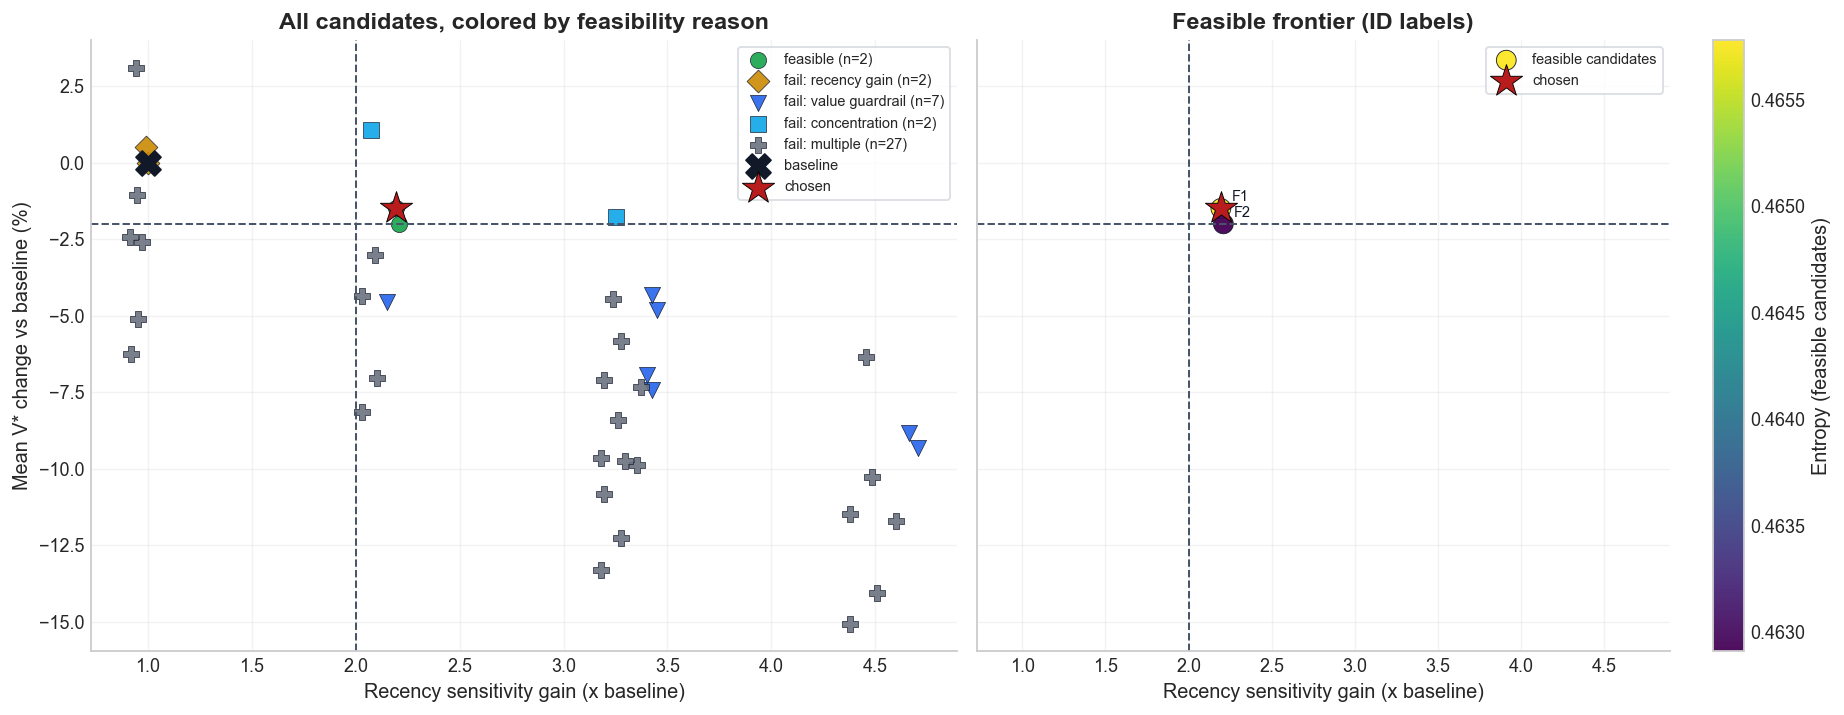

Chosen low-risk grid (deterministic from rule above):
memory_grid = (0.0, 0.9, 2.0)
recency_grid = (2.0, 12.0)


,candidate_id,mean_v_star_live,v_change_pct,recency_delta_vstar_overall,rec_gain_x,dominant_action_share,entropy_norm
0,F1,130.7378,-1.4921,0.2024,2.1944,0.6528,0.4658


In [27]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

if 'GRID_SEARCH_ROOT' in globals():
    grid_search_root = Path(GRID_SEARCH_ROOT)
else:
    project_root = Path.cwd().resolve()
    if not (project_root / 'runs').exists() and (project_root.parent / 'runs').exists():
        project_root = project_root.parent
    grid_search_root = project_root / 'runs' / 'dp' / 'grid_search'
candidates_dirs = sorted([
    p for p in grid_search_root.iterdir()
    if p.is_dir() and p.name.endswith('_constrained_40')
])
if not candidates_dirs:
    raise FileNotFoundError(f'No constrained sweep directory found under {grid_search_root}')

selected_run_dir = candidates_dirs[-1]
print('Using constrained sweep run:', selected_run_dir)
results = pd.read_csv(selected_run_dir / 'results.csv')

baseline_candidates = [
    ('[0.0, 1.0, 2.0]', '[0.0, 5.0]'),
    ('[0.0, 0.9, 2.0]', '[2.0, 12.0]'),
]
baseline = None
for m_grid, r_grid in baseline_candidates:
    mask = (results['memory_grid'] == m_grid) & (results['recency_grid'] == r_grid)
    if mask.sum() == 1:
        baseline = results[mask].iloc[0]
        break
if baseline is None:
    available_pairs = sorted({(m, r) for m, r in zip(results['memory_grid'], results['recency_grid'])})
    raise ValueError(
        'Expected at least one recognized baseline row in results.csv. '
        f'Available (memory_grid, recency_grid) examples: {available_pairs[:8]}'
    )

df = results.copy()
baseline_recency_delta = float(baseline['recency_delta_vstar_overall'])
if abs(baseline_recency_delta) < 1e-12:
    raise ValueError('Baseline recency_delta_vstar_overall is too close to zero for ratio-based comparison.')

df['v_change_pct'] = 100.0 * (df['mean_v_star_live'] - baseline['mean_v_star_live']) / baseline['mean_v_star_live']
df['rec_gain_x'] = df['recency_delta_vstar_overall'] / baseline_recency_delta
df['has_policy_collapse_warning'] = df['conceptual_warnings'].fillna('').astype(str).str.contains('policy_collapse')

constraints = {
    'hard_failures_eq_0': True,
    'max_dominant_action_share': 0.70,
    'max_value_drop_pct': 2.0,
    'min_recency_gain_x': 2.0,
    'exclude_policy_collapse_warning': True,
}

# Constraint-level diagnostics so every exclusion can be explained.
df['fail_hard_failures'] = df['hard_failures'] != 0
df['fail_concentration'] = df['dominant_action_share'] > constraints['max_dominant_action_share']
df['fail_value_drop'] = df['v_change_pct'] < -constraints['max_value_drop_pct']
df['fail_recency_gain'] = df['rec_gain_x'] < constraints['min_recency_gain_x']
df['fail_policy_collapse'] = df['has_policy_collapse_warning']

fail_cols = [
    'fail_hard_failures',
    'fail_concentration',
    'fail_value_drop',
    'fail_recency_gain',
    'fail_policy_collapse',
]
df['n_failed_constraints'] = df[fail_cols].sum(axis=1)
df['is_feasible'] = df['n_failed_constraints'] == 0

def _fail_reasons(row):
    reasons = []
    if bool(row['fail_hard_failures']):
        reasons.append('hard_failures')
    if bool(row['fail_concentration']):
        reasons.append('dominant_action_share')
    if bool(row['fail_value_drop']):
        reasons.append('value_drop')
    if bool(row['fail_recency_gain']):
        reasons.append('low_recency_gain')
    if bool(row['fail_policy_collapse']):
        reasons.append('policy_collapse')
    return reasons

df['fail_reasons'] = df.apply(_fail_reasons, axis=1)

def _reason_category(row):
    if bool(row['is_feasible']):
        return 'feasible'
    reasons = row['fail_reasons']
    if len(reasons) >= 2:
        return 'multiple_constraints'
    return reasons[0]

df['reason_category'] = df.apply(_reason_category, axis=1)

feasible = df[df['is_feasible']].copy()
ranked = feasible.sort_values(
    by=['mean_v_star_live', 'rec_gain_x', 'entropy_norm'],
    ascending=[False, False, False],
).reset_index(drop=True)

print('Selection constraints:')
display(pd.DataFrame([constraints]))

print('Baseline metrics:')
display(pd.DataFrame([{
    'memory_grid': baseline['memory_grid'],
    'recency_grid': baseline['recency_grid'],
    'mean_v_star_live': baseline['mean_v_star_live'],
    'recency_delta_vstar_overall': baseline['recency_delta_vstar_overall'],
    'dominant_action_share': baseline['dominant_action_share'],
    'entropy_norm': baseline['entropy_norm'],
}]).round(4))

reason_order = [
    'feasible',
    'low_recency_gain',
    'value_drop',
    'dominant_action_share',
    'policy_collapse',
    'hard_failures',
    'multiple_constraints',
]
reason_summary = (
    df['reason_category']
    .value_counts()
    .reindex(reason_order)
    .fillna(0)
    .astype(int)
    .rename_axis('reason_category')
    .reset_index(name='count')
)
reason_summary['share'] = reason_summary['count'] / len(df)
print('Why candidates are excluded (or feasible):')
display(reason_summary[reason_summary['count'] > 0].round(4))

excluded = df[~df['is_feasible']].copy()
if not excluded.empty:
    excluded['failed_reason_list'] = excluded['fail_reasons'].apply(lambda xs: ', '.join(xs))
    print('Excluded examples (with explicit failure reasons):')
    display(
        excluded
        .sort_values(['n_failed_constraints', 'rec_gain_x', 'v_change_pct'], ascending=[True, False, False])
        [[
            'memory_grid', 'recency_grid', 'failed_reason_list',
            'n_failed_constraints', 'hard_failures', 'dominant_action_share', 'v_change_pct', 'rec_gain_x',
        ]]
        .head(12)
        .round(4)
    )

print(f'Feasible candidates after constraints: {len(ranked)}')
if ranked.empty:
    raise RuntimeError('No feasible candidate under current constraints.')

ranked = ranked.copy()
ranked['candidate_id'] = [f'F{i+1}' for i in range(len(ranked))]

display(ranked[[
    'candidate_id', 'memory_grid', 'recency_grid',
    'mean_v_star_live', 'v_change_pct',
    'recency_delta_vstar_overall', 'rec_gain_x',
    'dominant_action_share', 'entropy_norm',
]].round(4))

chosen = ranked.iloc[0]
chosen_memory_grid = tuple(float(x) for x in ast.literal_eval(chosen['memory_grid']))
chosen_recency_grid = tuple(float(x) for x in ast.literal_eval(chosen['recency_grid']))

reason_style = {
    'feasible': {'color': '#16a34a', 'marker': 'o', 'label': 'feasible'},
    'low_recency_gain': {'color': '#ca8a04', 'marker': 'D', 'label': 'fail: recency gain'},
    'value_drop': {'color': '#2563eb', 'marker': 'v', 'label': 'fail: value guardrail'},
    'dominant_action_share': {'color': '#0ea5e9', 'marker': 's', 'label': 'fail: concentration'},
    'policy_collapse': {'color': '#f97316', 'marker': '^', 'label': 'fail: policy collapse'},
    'hard_failures': {'color': '#dc2626', 'marker': 'X', 'label': 'fail: hard checks'},
    'multiple_constraints': {'color': '#6b7280', 'marker': 'P', 'label': 'fail: multiple'},
}

fig, axes = plt.subplots(1, 2, figsize=(14.5, 5.6), sharex=True, sharey=True)
ax_left, ax_right = axes

# Left: all candidates with explicit reason categories.
for reason, style in reason_style.items():
    sub = df[df['reason_category'] == reason]
    if sub.empty:
        continue
    ax_left.scatter(
        sub['rec_gain_x'],
        sub['v_change_pct'],
        s=80,
        alpha=0.9,
        c=style['color'],
        marker=style['marker'],
        edgecolor='#111827',
        linewidth=0.4,
        label=f"{style['label']} (n={len(sub)})",
    )

ax_left.scatter(1.0, 0.0, marker='X', s=190, color='#111827', label='baseline', zorder=8)
ax_left.scatter(chosen['rec_gain_x'], chosen['v_change_pct'], marker='*', s=350, color='#b91c1c', edgecolor='black', linewidth=0.5, label='chosen', zorder=9)

ax_left.axvline(constraints['min_recency_gain_x'], linestyle='--', color='#475569', linewidth=1.1)
ax_left.axhline(-constraints['max_value_drop_pct'], linestyle='--', color='#475569', linewidth=1.1)
ax_left.set_title('All candidates, colored by feasibility reason')
ax_left.set_xlabel('Recency sensitivity gain (x baseline)')
ax_left.set_ylabel('Mean V* change vs baseline (%)')
ax_left.legend(loc='best', fontsize=8)

# Right: feasible-only frontier with candidate IDs.
feasible_plot = ranked.copy()
sc_feasible = ax_right.scatter(
    feasible_plot['rec_gain_x'],
    feasible_plot['v_change_pct'],
    s=120,
    c=feasible_plot['entropy_norm'],
    cmap='viridis',
    edgecolor='#111827',
    linewidth=0.5,
    alpha=0.95,
    label='feasible candidates',
)

for _, row in feasible_plot.iterrows():
    ax_right.annotate(
        row['candidate_id'],
        (row['rec_gain_x'], row['v_change_pct']),
        textcoords='offset points',
        xytext=(6, 4),
        fontsize=8,
        color='#111827',
    )

ax_right.scatter(chosen['rec_gain_x'], chosen['v_change_pct'], marker='*', s=350, color='#b91c1c', edgecolor='black', linewidth=0.5, label='chosen', zorder=9)
ax_right.axvline(constraints['min_recency_gain_x'], linestyle='--', color='#475569', linewidth=1.1)
ax_right.axhline(-constraints['max_value_drop_pct'], linestyle='--', color='#475569', linewidth=1.1)
ax_right.set_title('Feasible frontier (ID labels)')
ax_right.set_xlabel('Recency sensitivity gain (x baseline)')
ax_right.legend(loc='best', fontsize=8)

cbar = fig.colorbar(sc_feasible, ax=ax_right)
cbar.set_label('Entropy (feasible candidates)')

plt.tight_layout()
plt.show()

print('Chosen low-risk grid (deterministic from rule above):')
print('memory_grid =', chosen_memory_grid)
print('recency_grid =', chosen_recency_grid)
display(pd.DataFrame([chosen[[
    'candidate_id', 'mean_v_star_live', 'v_change_pct',
    'recency_delta_vstar_overall', 'rec_gain_x',
    'dominant_action_share', 'entropy_norm',
]].to_dict()]).round(4))
